## Set up

In [ ]:
# --- Importing Required Libraries ---
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib as mpl
from collections import Counter

# Set a clean, professional style
plt.style.use('seaborn-v0_8-whitegrid')

# Typography settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Figure settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.autolayout'] = True

# Axes settings
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'

# Color palette - colorblind friendly
custom_colors = [
    '#4e79a7', '#f28e2c', '#e15759', '#76b7b2',
    '#59a14f', '#edc949', '#af7aa1', '#ff9da7',
    '#9c755f', '#bab0ab'
]
sns.set_palette(custom_colors)


# Define a styling function for consistent plot appearance
def style_plot(ax, title=None, xlabel=None, ylabel=None):
    """Apply consistent styling to plots"""
    if title:
        ax.set_title(title, fontweight='bold', pad=20)
    if xlabel:
        ax.set_xlabel(xlabel, labelpad=10)
    if ylabel:
        ax.set_ylabel(ylabel, labelpad=10)

    ax.set_facecolor('#f8f9fa')

    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        spine.set_color('#cccccc')

    return ax


## LOADING THE DATASET

In [ ]:
def load_new_york_city_airbnb_dataset(file_path):
    """
    Loads the New York City Airbnb dataset from a given CSV file path.
    This function prints basic information to confirm successful loading.

    Parameters:
        file_path (str): Path to the CSV file containing the New York City Airbnb dataset.

    Returns:
        pandas.DataFrame: A DataFrame containing the raw Airbnb data.
    """
    try:
        print(f"Loading New York City Airbnb dataset from: {file_path}")
        raw_new_york_city_airbnb_data = pd.read_csv(file_path)
        print(
            f"Successfully loaded the dataset with "
            f"{raw_new_york_city_airbnb_data.shape[0]:,} rows and {raw_new_york_city_airbnb_data.shape[1]} columns."
        )
        return raw_new_york_city_airbnb_data
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found. Please check the file path.")
        return None
    except Exception as error:
        print(f"Error loading data: {str(error)}")
        return None


# Adjust the file path as needed if your CSV is located elsewhere.
raw_new_york_city_airbnb_data = load_new_york_city_airbnb_dataset('AB_NYC_2019.csv')

if raw_new_york_city_airbnb_data is not None:
    # Create a visual separator for better readability
    print("\n" + "=" * 60)
    print("NEW YORK CITY AIRBNB DATASET OVERVIEW".center(60))
    print("=" * 60)

    # Displaying basic info to get a sense of the dataset's shape and columns
    print("\n--- Basic Dataset Info ---")
    raw_new_york_city_airbnb_data.info()

    # Check for missing values
    missing_values_count = raw_new_york_city_airbnb_data.isnull().sum()
    if missing_values_count.sum() > 0:
        print("\n--- Missing Values Summary ---")
        print(missing_values_count[missing_values_count > 0].to_string())

    print("\n--- First 5 Rows of the Dataset ---")
    display(raw_new_york_city_airbnb_data.head())

    print("\n--- Summary Statistics (Numerical Columns) ---")
    display(raw_new_york_city_airbnb_data.describe().round(2))

    # Add data types distribution for better understanding
    print("\n--- Data Types Distribution ---")
    print(raw_new_york_city_airbnb_data.dtypes.value_counts().to_string())

    # Add a quick column overview
    print("\n--- Column Names and Types ---")
    for column_name, data_type in zip(raw_new_york_city_airbnb_data.columns, raw_new_york_city_airbnb_data.dtypes):
        print(f"- {column_name}: {data_type}")

## Task 1: Data Cleaning

To prepare the NYC Airbnb dataset for analysis, I performed a series of data cleaning steps to handle missing values, outliers, and potential inconsistencies. Below is a summary of the cleaning process:

### Missing Values
- **`name`**: Replaced missing values with `"Unnamed Listing"` to retain rows without breaking downstream tasks.
- **`host_name`**: Filled missing entries with `"Unknown Host"` to preserve data integrity.
- **`reviews_per_month`**: Filled missing values with `0`, since listings without reviews logically have zero reviews per month.
- **`last_review`**: Converted to datetime format; missing values were left as `NaT` since they indicate no reviews — this is valid.

### Outlier Handling
- **`price`**:
  - Visualized the price distribution.
  - Removed listings with prices greater than $10,000 (none were found).
  - Removed any negative prices (none found).
- **`minimum_nights`**:
  - Visualized the distribution.
  - Removed listings with `minimum_nights` > 365, which are likely errors or anomalies.

### Duplicates
- Checked for exact duplicate rows and removed them (none were found).

### Data Integrity Checks
- Confirmed valid values for `neighbourhood_group` and `room_type`.
- Re-checked for missing values after cleaning.

### Summary
- **Original dataset shape**: 48,895 rows × 16 columns
- **Cleaned dataset shape**: 48,881 rows × 16 columns
- **Total rows removed**: 14 (due to extreme `minimum_nights`)

In [ ]:
def clean_new_york_city_airbnb_dataset(original_dataframe):
    """
    Cleans the New York City Airbnb dataset by handling missing values, removing outliers,
    fixing inconsistencies, and checking for duplicates.

    Parameters:
        original_dataframe (pandas.DataFrame): The original New York City Airbnb dataset to clean.

    Returns:
        pandas.DataFrame: A DataFrame that has been cleaned of major issues.
    """
    print("\n--- Task 1: Data Cleaning ---")

    # Work on a copy of the dataset to preserve the original
    cleaned_dataframe = original_dataframe.copy()

    # Step 1: Identify missing values
    print("\nMissing values in each column (only those with > 0 missing):")
    missing_value_counts = cleaned_dataframe.isnull().sum()
    print(missing_value_counts[missing_value_counts > 0])

    # Step 2: Fix missing 'name' entries
    cleaned_dataframe['name'].fillna('Unnamed Listing', inplace=True)

    # Step 3: Fix missing 'host_name' entries
    cleaned_dataframe['host_name'].fillna('Unknown Host', inplace=True)

    # Step 4: Deal with missing 'reviews_per_month' (0 if no reviews)
    cleaned_dataframe['reviews_per_month'].fillna(0, inplace=True)

    # Step 5: Convert 'last_review' to datetime
    cleaned_dataframe['last_review'] = pd.to_datetime(cleaned_dataframe['last_review'], errors='coerce')

    # Step 6: Check for extreme values in 'price'
    print("\nPrice statistics before handling extreme outliers:")
    print(cleaned_dataframe['price'].describe())

    fig, ax = plt.subplots()
    sns.histplot(cleaned_dataframe['price'], bins=50, kde=True, ax=ax)
    style_plot(ax, title='Price Distribution Before Removing Extreme Outliers',
               xlabel='Price (USD)', ylabel='Frequency')
    ax.set_xlim(0, 1000)
    plt.show()

    # Remove absurdly high prices
    price_threshold = 10000
    high_price_listings = cleaned_dataframe['price'] > price_threshold
    print(f"\nListings with price > ${price_threshold}: {high_price_listings.sum()}")
    cleaned_dataframe = cleaned_dataframe[cleaned_dataframe['price'] <= price_threshold]

    # Remove negative prices
    negative_price_listings = cleaned_dataframe['price'] < 0
    print(f"Listings with negative prices: {negative_price_listings.sum()}")
    cleaned_dataframe = cleaned_dataframe[cleaned_dataframe['price'] >= 0]

    # Step 7: Check for unrealistic minimum_nights values
    print("\nMinimum Nights statistics before removing outliers:")
    print(cleaned_dataframe['minimum_nights'].describe())

    fig, ax = plt.subplots()
    sns.histplot(cleaned_dataframe['minimum_nights'], bins=50, kde=True, ax=ax)
    style_plot(ax, title='Minimum Nights Distribution Before Removing Outliers',
               xlabel='Minimum Nights', ylabel='Frequency')
    ax.set_xlim(0, 100)
    plt.show()

    # Remove listings with unrealistic minimum_nights
    minimum_nights_threshold = 365
    outlier_minimum_nights = cleaned_dataframe['minimum_nights'] > minimum_nights_threshold
    print(f"\nListings with minimum_nights > {minimum_nights_threshold}: {outlier_minimum_nights.sum()}")
    cleaned_dataframe = cleaned_dataframe[cleaned_dataframe['minimum_nights'] <= minimum_nights_threshold]

    # Step 8: Check for duplicates
    duplicate_count = cleaned_dataframe.duplicated().sum()
    print(f"\nDuplicate rows found: {duplicate_count}")

    if duplicate_count > 0:
        cleaned_dataframe = cleaned_dataframe.drop_duplicates()
        print("Duplicate rows have been removed.")

    # Step 9: Basic integrity checks
    print("\nUnique Neighborhood Groups found:")
    print(cleaned_dataframe['neighbourhood_group'].unique())

    print("\nUnique Room Types found:")
    print(cleaned_dataframe['room_type'].unique())

    # Final check for missing data after cleaning
    print("\nAny remaining missing values after cleaning:")
    remaining_missing_values = cleaned_dataframe.isnull().sum()
    print(remaining_missing_values[remaining_missing_values > 0])

    # Summary of data cleaning process
    print("\nSummary of cleaning process:")
    print(f"Original shape: {original_dataframe.shape}")
    print(f"Cleaned shape: {cleaned_dataframe.shape}")
    print(f"Rows removed: {original_dataframe.shape[0] - cleaned_dataframe.shape[0]}")

    return cleaned_dataframe


# Call the cleaning function and store the result
final_cleaned_new_york_city_airbnb_data = clean_new_york_city_airbnb_dataset(raw_new_york_city_airbnb_data)


## Task 2a: Top 5 and Bottom 5 Neighborhoods by Price

In this analysis, I examined how average Airbnb prices vary across individual neighborhoods
(by the `neighbourhood` field), filtering out neighborhoods with fewer than 5 listings to ensure statistical reliability.

### What I Did:
- Grouped listings by `neighbourhood` and calculated:
  - **Average**, **median**, **minimum**, and **maximum** prices
  - **Listing count** for each neighborhood
- Filtered out neighborhoods with ≤5 listings
- Extracted the:
  - **Top 5 most expensive neighborhoods**
  - **Bottom 5 cheapest neighborhoods**
- Created:
  - A **dual bar chart** showing both groups with:
    - Average price labels
    - Listing counts
    - Price range indicators (min-max bars)
  - A **combined bar chart** comparing both groups side-by-side:
    - Highlighting median price (dashed white lines)

### Results:

####  Top 5 Most Expensive Neighborhoods (by average price):
| Neighborhood          | Avg Price | Median Price | Listings |
|-----------------------|-----------|--------------|----------|
| **Tribeca**           | $490.64   | $295         | 177      |
| **Sea Gate**          | $487.86   | $125         | 7        |
| **Riverdale**         | $442.09   | $150         | 11       |
| **Battery Park City** | $367.09   | $195         | 69       |
| **Flatiron District** | $341.92   | $225         | 80       |

####  Bottom 5 Least Expensive Neighborhoods:
| Neighborhood    | Avg Price | Median Price | Listings |
|-----------------|-----------|--------------|----------|
| **Bull's Head** | $47.33    | $45          | 6        |
| **Hunts Point** | $50.50    | $40          | 18       |
| **Tremont**     | $51.55    | $41          | 11       |
| **Soundview**   | $53.47    | $49          | 15       |
| **Bronxdale**   | $57.11    | $50          | 19       |

### Key Takeaways

- **Tribeca** had the **highest average price** at **\$490.64**, followed closely by **Sea Gate** (\$487.86) and **Riverdale** (\$442.09).
- **Bull's Head** had the **lowest average price** at just **\$47.33**.
- Significant gaps between **average** and **median** prices in neighborhoods like **Sea Gate** and **Riverdale** suggest **price skewness** — likely caused by a few very expensive listings.
- Including **listing counts** provides important context:
  - **Tribeca's** high average is supported by **177 listings** (statistically robust).
  - **Sea Gate** had only **7 listings**, making its high average more susceptible to outliers.


                 TASK 2a: TOP AND BOTTOM NEIGHBORHOODS BY PRICE                 

Analyzing 190 neighborhoods with more than 5 listings...

----------------------------------------
   TOP 5 MOST EXPENSIVE NEIGHBORHOODS   
----------------------------------------


neighbourhood  average_price  median_price  min_price  max_price  \
170            Tribeca         490.64         295.0         60       8500   
150           Sea Gate         487.86         125.0         71       1485   
144          Riverdale         442.09         150.0         49       2500   
5    Battery Park City         367.09         195.0         55       7500   
68   Flatiron District         341.92         225.0         65       2000   

     listing_count  
170            177  
150              7  
144             11  
5               69  
68              80


----------------------------------------
 BOTTOM 5 LEAST EXPENSIVE NEIGHBORHOODS 
----------------------------------------


neighbourhood  average_price  median_price  min_price  max_price  \
24    Bull's Head          47.33          45.0         25         80   
90    Hunts Point          50.50          40.0         35        150   
169       Tremont          51.55          41.0         25        150   
154     Soundview          53.47          49.0         28        103   
21      Bronxdale          57.11          50.0         25        100   

     listing_count  
24               6  
90              18  
169             11  
154             15  
21              19

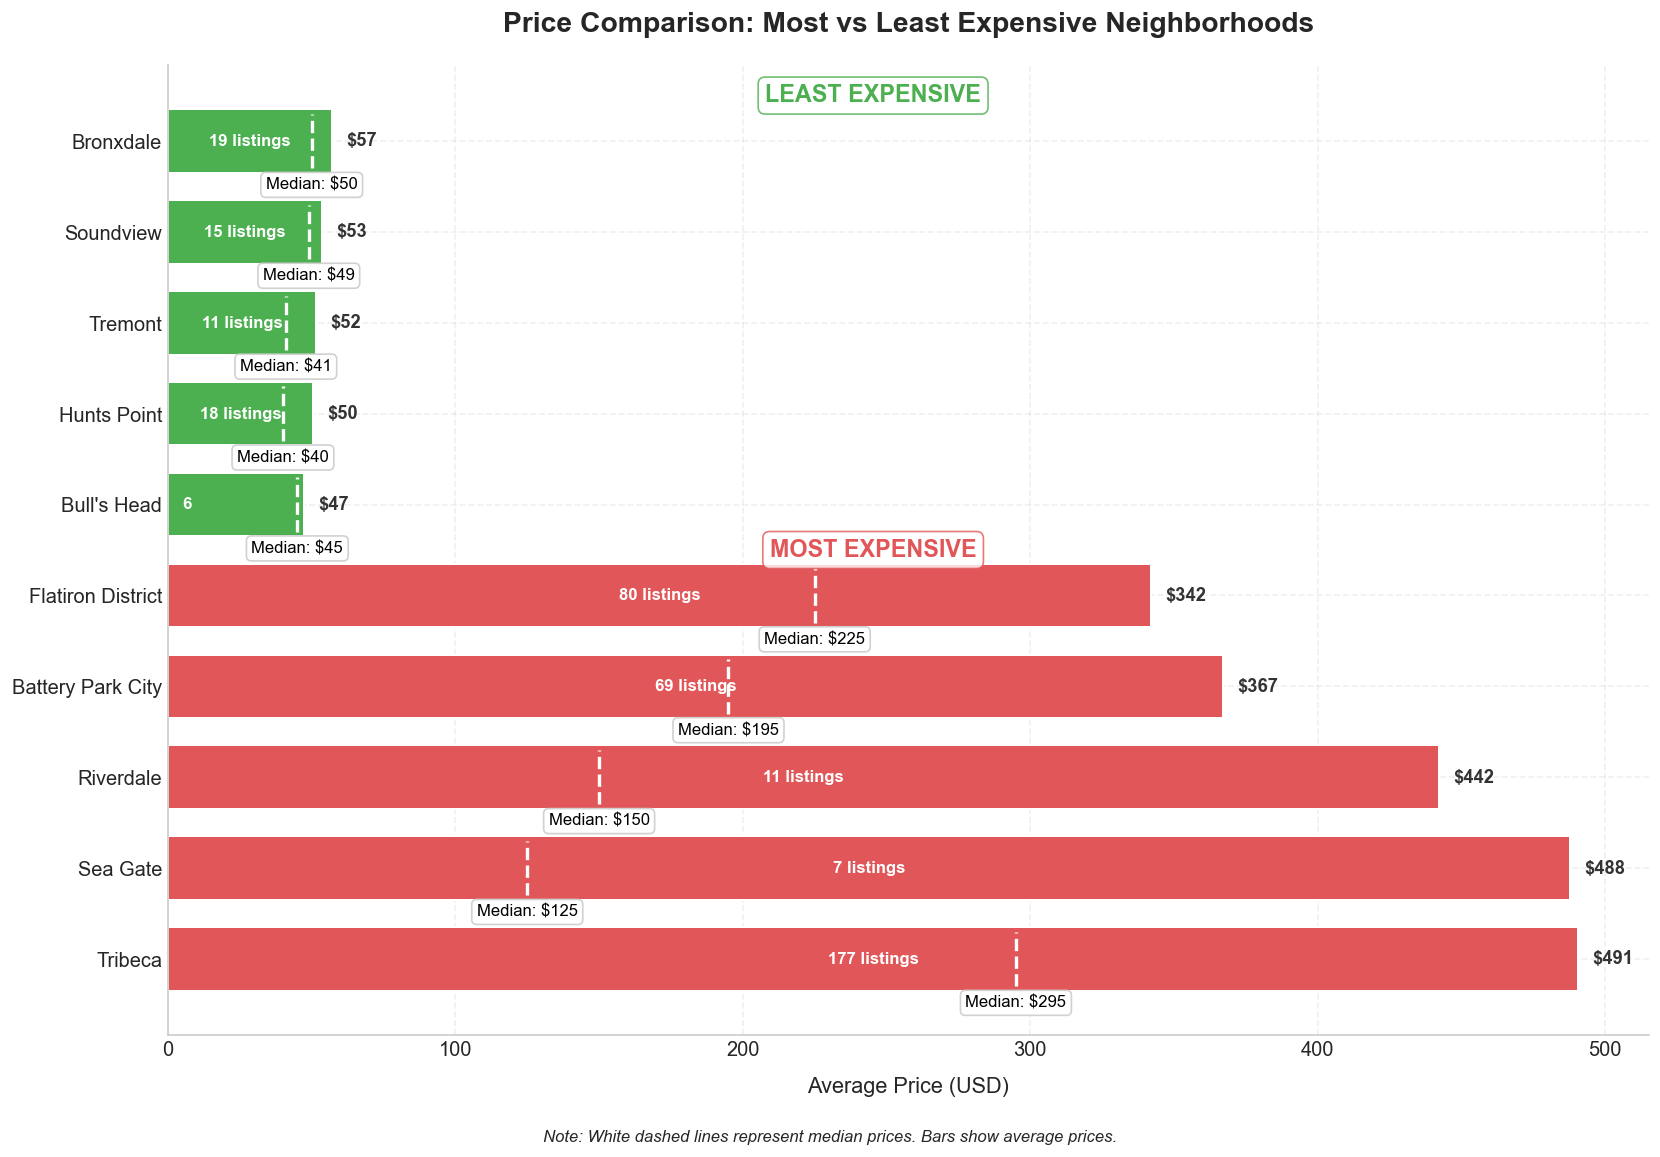

In [79]:
def analyze_top_bottom_neighborhoods(df):
    """
    Analyzes and identifies the top 5 and bottom 5 neighborhoods based on average price,
    considering only neighborhoods with more than 5 listings. Displays annotated visualizations
    and summarizes key findings.

    Parameters:
        df (pandas.DataFrame): Cleaned Airbnb DataFrame.

    Returns:
        tuple: (top_5_neighborhoods, bottom_5_neighborhoods) DataFrames
    """
    print("\n" + "=" * 80)
    print("TASK 2a: TOP AND BOTTOM NEIGHBORHOODS BY PRICE".center(80))
    print("=" * 80)

    # Filter neighborhoods with more than 5 listings
    neighborhood_counts = df.groupby('neighbourhood').size()
    valid_neighborhoods = neighborhood_counts[neighborhood_counts > 5].index
    filtered_df = df[df['neighbourhood'].isin(valid_neighborhoods)]

    print(f"\nAnalyzing {len(valid_neighborhoods)} neighborhoods with more than 5 listings...")

    # Compute statistics for each neighborhood
    neighborhood_prices = filtered_df.groupby('neighbourhood').agg(
        average_price=('price', 'mean'),
        median_price=('price', 'median'),
        min_price=('price', 'min'),
        max_price=('price', 'max'),
        listing_count=('id', 'count')
    ).reset_index()

    # Round monetary columns for cleaner display
    price_columns = ['average_price', 'median_price', 'min_price', 'max_price']
    neighborhood_prices[price_columns] = neighborhood_prices[price_columns].round(2)

    # Extract top 5 and bottom 5 neighborhoods based on average price
    top_5 = neighborhood_prices.sort_values('average_price', ascending=False).head(5)
    bottom_5 = neighborhood_prices.sort_values('average_price', ascending=True).head(5)

    # Display results clearly
    print("\n" + "-" * 40)
    print("TOP 5 MOST EXPENSIVE NEIGHBORHOODS".center(40))
    print("-" * 40)
    display(top_5)

    print("\n" + "-" * 40)
    print("BOTTOM 5 LEAST EXPENSIVE NEIGHBORHOODS".center(40))
    print("-" * 40)
    display(bottom_5)

    # --- Visualization Settings ---
    top_color = '#e15759'  # Red tone for expensive
    bottom_color = '#4CAF50'  # Green tone for affordable

    # --- HORIZONTAL BAR CHART (much more readable) ---
    import matplotlib.patches as mpatches

    fig, ax = plt.subplots(figsize=(14, 10), dpi=120)

    # Concatenate data and assign category labels
    combined = pd.concat([
        top_5.assign(category='Most Expensive'),
        bottom_5.assign(category='Least Expensive')
    ])

    # Create positions for horizontal bars
    y_positions = list(range(len(combined)))

    # Map colors based on category
    colors = [top_color if cat == 'Most Expensive' else bottom_color for cat in combined['category']]

    # Create horizontal bar plot
    hbars = ax.barh(
        y=y_positions,
        width=combined['average_price'],
        color=colors,
        edgecolor='white',
        linewidth=1.2,
        height=0.7
    )

    # Set neighborhood names as y-tick labels (no rotation needed)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(combined['neighbourhood'], fontsize=12)

    # Add a subtle grid only on the x-axis
    ax.xaxis.grid(True, linestyle='--', alpha=0.3, color='#cccccc')
    ax.set_axisbelow(True)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add average price labels at the end of each bar
    for i, bar in enumerate(hbars):
        width = bar.get_width()
        ax.text(
            width + 5,  # Position just outside the bar
            bar.get_y() + bar.get_height() / 2,
            f"${width:.0f}",
            va='center',
            ha='left',
            fontsize=11,
            fontweight='bold',
            color='#333333'
        )

    # Add median markers and labels (consistently positioned)
    for i, row in enumerate(combined.itertuples()):
        # Draw median line
        ax.plot(
            [row.median_price, row.median_price],
            [y_positions[i] - 0.3, y_positions[i] + 0.3],
            color='white',
            linestyle='--',
            linewidth=2
        )

        # Add median label (always below the bar)
        ax.text(
            row.median_price,
            y_positions[i] - 0.4,  # Consistent position below the bar
            f"Median: ${row.median_price:.0f}",
            ha='center',
            va='top',
            fontsize=10,
            color='black',
            bbox=dict(
                facecolor='white',
                edgecolor='#cccccc',
                boxstyle='round,pad=0.3',
                alpha=0.9
            )
        )

    # Add listing counts inside bars
    for i, row in enumerate(combined.itertuples()):
        # Only add text if bar is wide enough
        if row.average_price > 50:  # Minimum width for text
            ax.text(
                row.average_price / 2,  # Middle of the bar
                y_positions[i],
                f"{row.listing_count} listings",
                ha='center',
                va='center',
                fontsize=10,
                fontweight='bold',
                color='white'
            )
        else:
            # For narrow bars, place text outside
            ax.text(
                5,  # Just at the start of the bar
                y_positions[i],
                f"{row.listing_count}",
                ha='left',
                va='center',
                fontsize=10,
                fontweight='bold',
                color='white'
            )

    # Add category labels to separate the groups
    ax.text(
        combined['average_price'].max() * 0.5,
        len(top_5) - 0.5,
        "MOST EXPENSIVE",
        ha='center',
        va='center',
        fontsize=14,
        fontweight='bold',
        color=top_color,
        bbox=dict(
            facecolor='white',
            edgecolor=top_color,
            boxstyle='round,pad=0.3',
            alpha=0.8
        )
    )

    ax.text(
        combined['average_price'].max() * 0.5,
        len(top_5) + len(bottom_5) - 0.5,
        "LEAST EXPENSIVE",
        ha='center',
        va='center',
        fontsize=14,
        fontweight='bold',
        color=bottom_color,
        bbox=dict(
            facecolor='white',
            edgecolor=bottom_color,
            boxstyle='round,pad=0.3',
            alpha=0.8
        )
    )

    # Axis labels and title
    ax.set_xlabel("Average Price (USD)", fontsize=13, labelpad=10)
    ax.set_title("Price Comparison: Most vs Least Expensive Neighborhoods",
                 fontsize=17, fontweight='bold', pad=20)

    # Add explanatory annotation
    fig.text(
        0.5, 0.01,
        "Note: White dashed lines represent median prices. Bars show average prices.",
        ha='center',
        fontsize=10,
        fontstyle='italic'
    )

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig('neighborhood_price_comparison_horizontal.png', dpi=300, bbox_inches='tight')
    plt.show()

    return top_5, bottom_5


# Call Function
top_5_neighborhoods, bottom_5_neighborhoods = analyze_top_bottom_neighborhoods(final_cleaned_new_york_city_airbnb_data)


## Task 2b: Price Variation by Neighborhood Group

To explore broader regional trends, I analyzed average Airbnb prices across **neighborhood groups** rather than individual neighborhoods. This provides insight into how borough-level location influences price levels.

### What I Did:
- Grouped listings by `neighbourhood_group`
- Calculated:
  - Average price
  - Median price
  - Min & Max price
  - Number of listings per group
- Plotted:
  - A **bar chart** of average prices
  - A **boxplot** showing price distributions (filtered under $1000 for clarity)

### Observations:
- **Manhattan** has the highest average price, followed by **Brooklyn** and **Staten Island**.
- **Bronx** and **Queens** are the most affordable on average.
- Boxplots show wider price variation in **Manhattan** and **Brooklyn**, likely due to outliers.

### Key Findings:
- **Highest average price**: Manhattan (\$196.88)
- **Lowest average price**: Bronx (\$87.50)
- **Price difference between highest and lowest**: \$109.38




--- Task 2b: Price Variation Across Neighborhood Groups ---

Neighborhood Group Price Summary:


neighbourhood_group  average_price  median_price  min_price  max_price  \
2           Manhattan     196.878919         150.0          0      10000   
1            Brooklyn     124.396507          90.0          0      10000   
4       Staten Island     114.812332          75.0         13       5000   
3              Queens      99.493997          75.0         10      10000   
0               Bronx      87.496792          65.0          0       2500   

   listing_count  
2          21655  
1          20098  
4            373  
3           5664  
0           1091

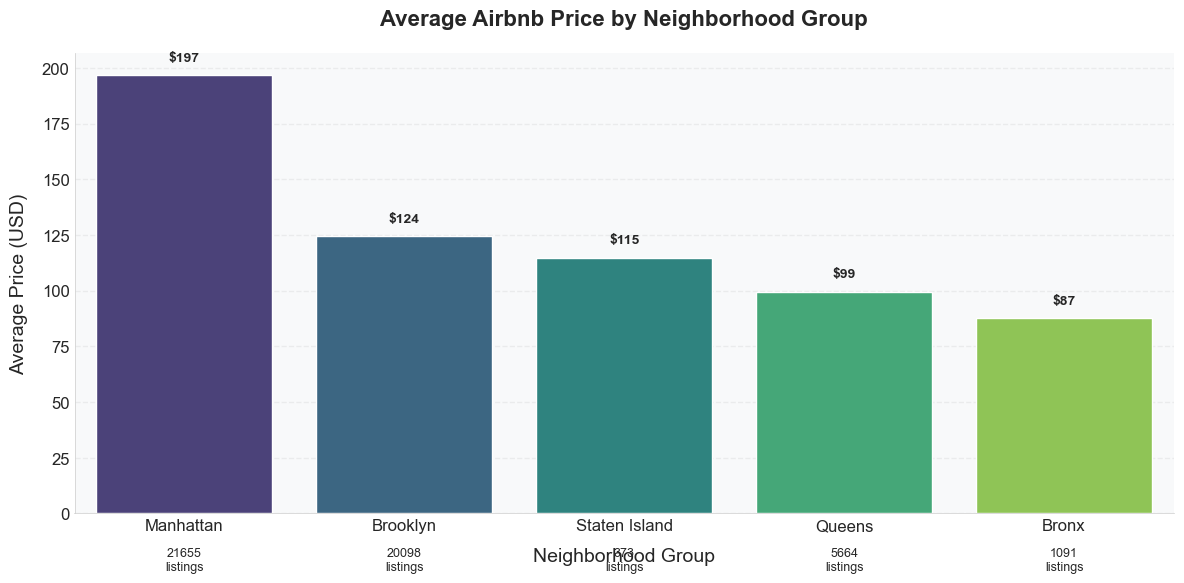

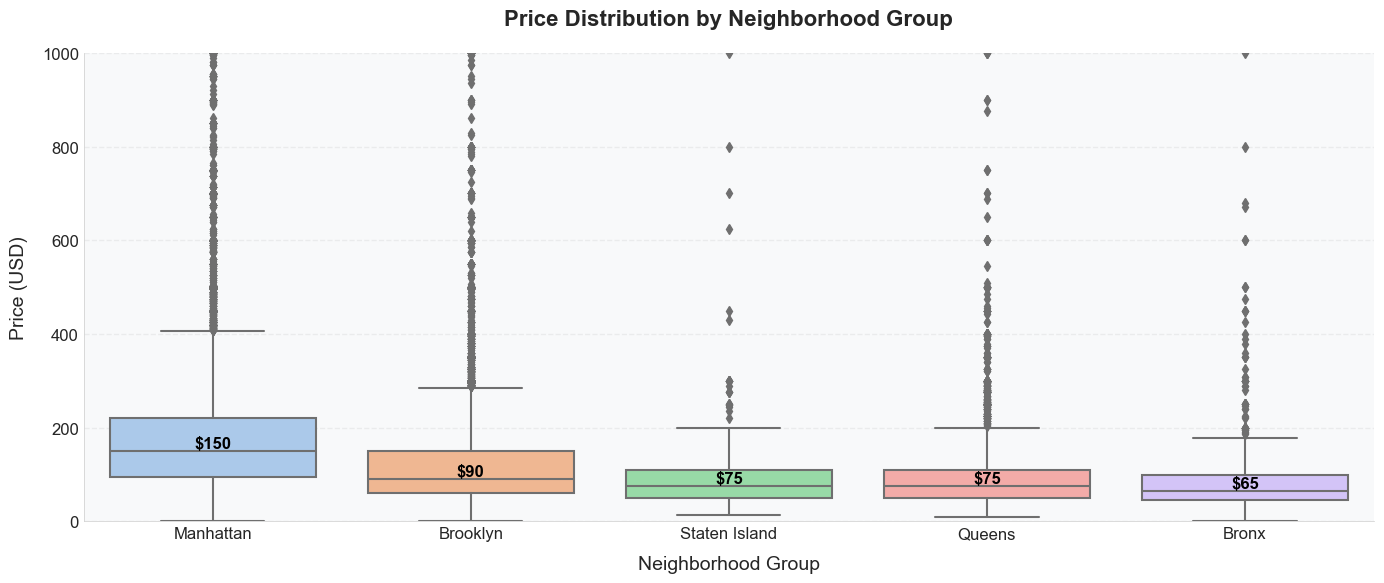

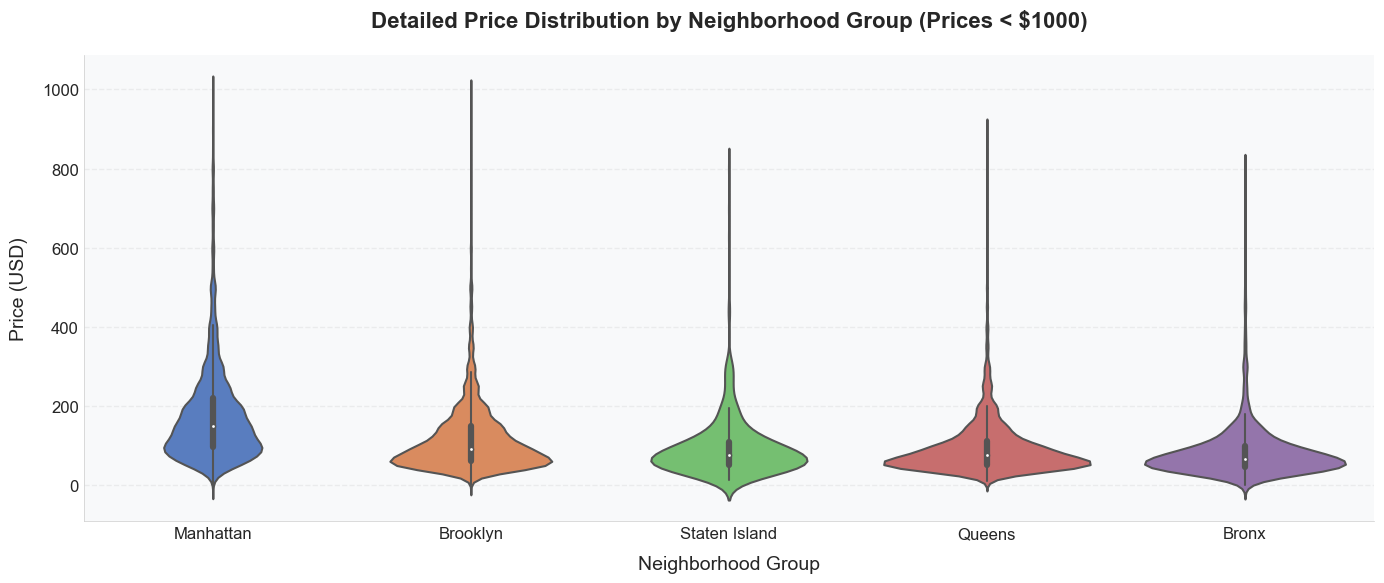


Key Findings:
• Highest average price: Manhattan ($196.88)
• Lowest average price: Bronx ($87.50)
• Price difference between highest and lowest: $109.38


In [80]:
def analyze_price_by_neighborhood_group(df):
    """
    Analyzes price variation across different neighborhood groups
    and visualizes the trend using average prices and price distributions.

    Parameters:
        df (pandas.DataFrame): Cleaned Airbnb DataFrame.

    Returns:
        pandas.DataFrame: Grouped price summary statistics by neighborhood group.
    """
    print("\n--- Task 2b: Price Variation Across Neighborhood Groups ---")

    # Group by neighborhood group and compute summary stats
    group_prices = df.groupby('neighbourhood_group').agg(
        average_price=('price', 'mean'),
        median_price=('price', 'median'),
        min_price=('price', 'min'),
        max_price=('price', 'max'),
        listing_count=('id', 'count')
    ).reset_index()

    # Sort neighborhood groups by average price
    group_prices_sorted = group_prices.sort_values('average_price', ascending=False)
    ordered_groups = group_prices_sorted['neighbourhood_group']

    print("\nNeighborhood Group Price Summary:")
    display(group_prices_sorted)

    # === Plot 1: Bar plot of average prices ===
    plt.figure(figsize=(12, 6), dpi=100)
    ax = sns.barplot(
        data=group_prices_sorted,
        x='neighbourhood_group',
        y='average_price',
        palette='viridis',
        order=ordered_groups
    )
    style_plot(ax,
               title='Average Airbnb Price by Neighborhood Group',
               xlabel='Neighborhood Group',
               ylabel='Average Price (USD)')

    # Add value labels on bars
    for i, v in enumerate(group_prices_sorted['average_price']):
        ax.text(i, v + 5, f"${v:.0f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Add listing count below each bar
    for i, (count, group) in enumerate(zip(group_prices_sorted['listing_count'], ordered_groups)):
        ax.text(i, -15, f"{count}\nlistings", ha='center', va='top', fontsize=9)

    plt.tight_layout()
    plt.show()

    # === Plot 2: Box plot of price distribution ===
    plt.figure(figsize=(14, 6), dpi=100)
    ax = sns.boxplot(
        data=df,
        x='neighbourhood_group',
        y='price',
        palette='pastel',
        order=ordered_groups
    )
    style_plot(ax,
               title='Price Distribution by Neighborhood Group',
               xlabel='Neighborhood Group',
               ylabel='Price (USD)')

    # Add median price labels
    medians = df.groupby('neighbourhood_group')['price'].median()
    for i, median in enumerate(medians[ordered_groups]):
        ax.text(i, median, f'${median:.0f}', ha='center', va='bottom', fontweight='bold', color='black')

    plt.ylim(0, 1000)  # Limit y-axis to focus on majority of data
    plt.tight_layout()
    plt.show()

    # === Plot 3: Violin plot for detailed price distribution ===
    plt.figure(figsize=(14, 6), dpi=100)
    ax = sns.violinplot(
        data=df[df['price'] < 1000],  # Filter extreme prices for better visualization
        x='neighbourhood_group',
        y='price',
        palette='muted',
        order=ordered_groups
    )
    style_plot(ax,
               title='Detailed Price Distribution by Neighborhood Group (Prices < $1000)',
               xlabel='Neighborhood Group',
               ylabel='Price (USD)')

    plt.tight_layout()
    plt.show()

    print("\nKey Findings:")
    print(
        f"• Highest average price: {group_prices_sorted.iloc[0]['neighbourhood_group']} (${group_prices_sorted.iloc[0]['average_price']:.2f})")
    print(
        f"• Lowest average price: {group_prices_sorted.iloc[-1]['neighbourhood_group']} (${group_prices_sorted.iloc[-1]['average_price']:.2f})")
    print(
        f"• Price difference between highest and lowest: ${group_prices_sorted.iloc[0]['average_price'] - group_prices_sorted.iloc[-1]['average_price']:.2f}")

    return group_prices_sorted


# Call the function
neighborhood_group_price_summary = analyze_price_by_neighborhood_group(final_cleaned_new_york_city_airbnb_data)


## Task 3: Pairwise Pearson Correlation Analysis

In this task, I analyzed how various numerical features in the Airbnb dataset correlate with each other using **Pearson correlation coefficients**. This helps identify linear relationships between variables.

### What I Did:
- Computed the **Pearson correlation matrix** for relevant numerical columns, such as:
  - `price`, `minimum_nights`, `number_of_reviews`, `reviews_per_month`, `availability_365`
- Visualized correlations using:
  - A **heatmap** of the correlation matrix
  - A **pairplot** to explore pairwise relationships
  - Two individual scatter plots showing the strongest positive and negative correlations

### Key Correlation Insights:
- **Most Positive Correlation**: `number_of_reviews` and `reviews_per_month` = **0.59**
  - As the number of total reviews increases, the average number of reviews per month also tends to increase.
- **Most Negative Correlation**: `minimum_nights` and `reviews_per_month` = **-0.15**
  - Listings with higher minimum stay requirements tend to receive fewer reviews per month.

### Interpretation:
- The positive correlation between review-related variables suggests consistency in engagement: highly reviewed listings continue to attract attention.
- The negative correlation with `minimum_nights` implies that restrictive stay durations may reduce booking frequency.


--- Task 3: Pairwise Pearson Correlation Analysis ---

Correlation Matrix (Pearson):


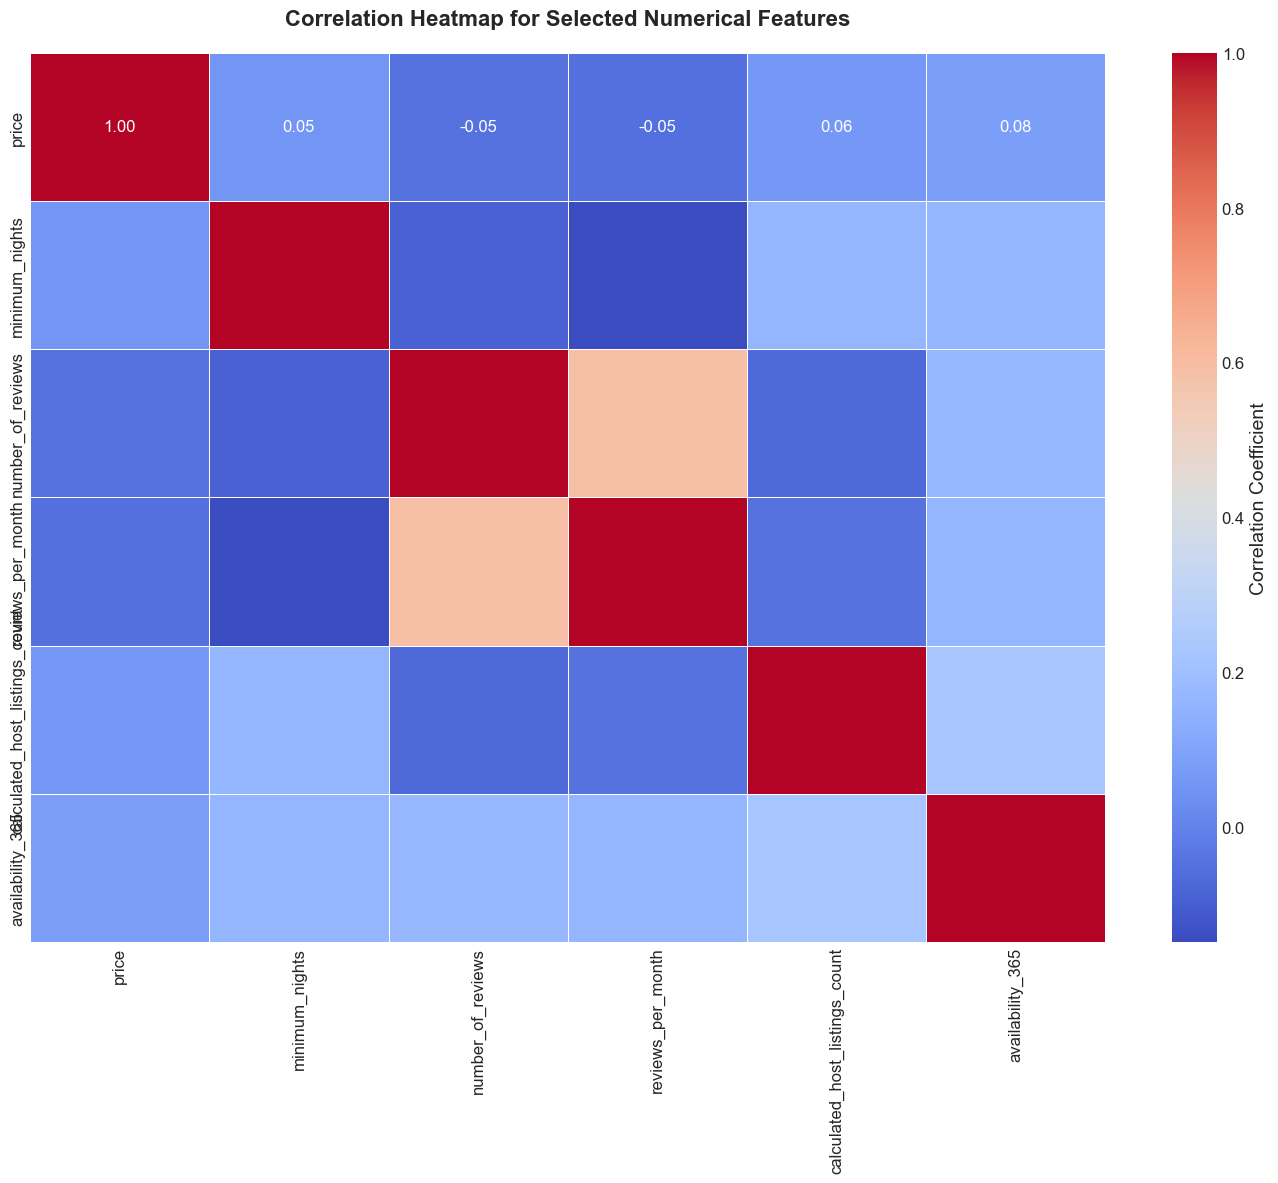


Most Positive Correlation: number_of_reviews and reviews_per_month = 0.59
Most Negative Correlation: minimum_nights and reviews_per_month = -0.15


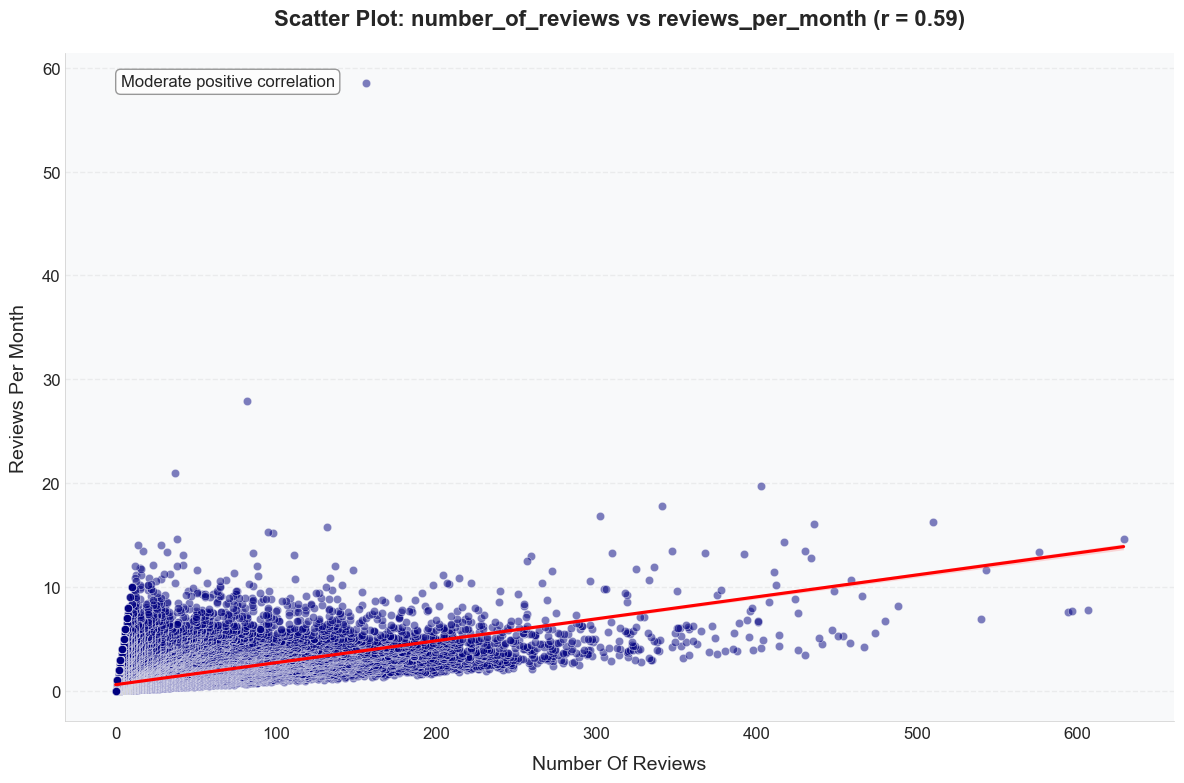

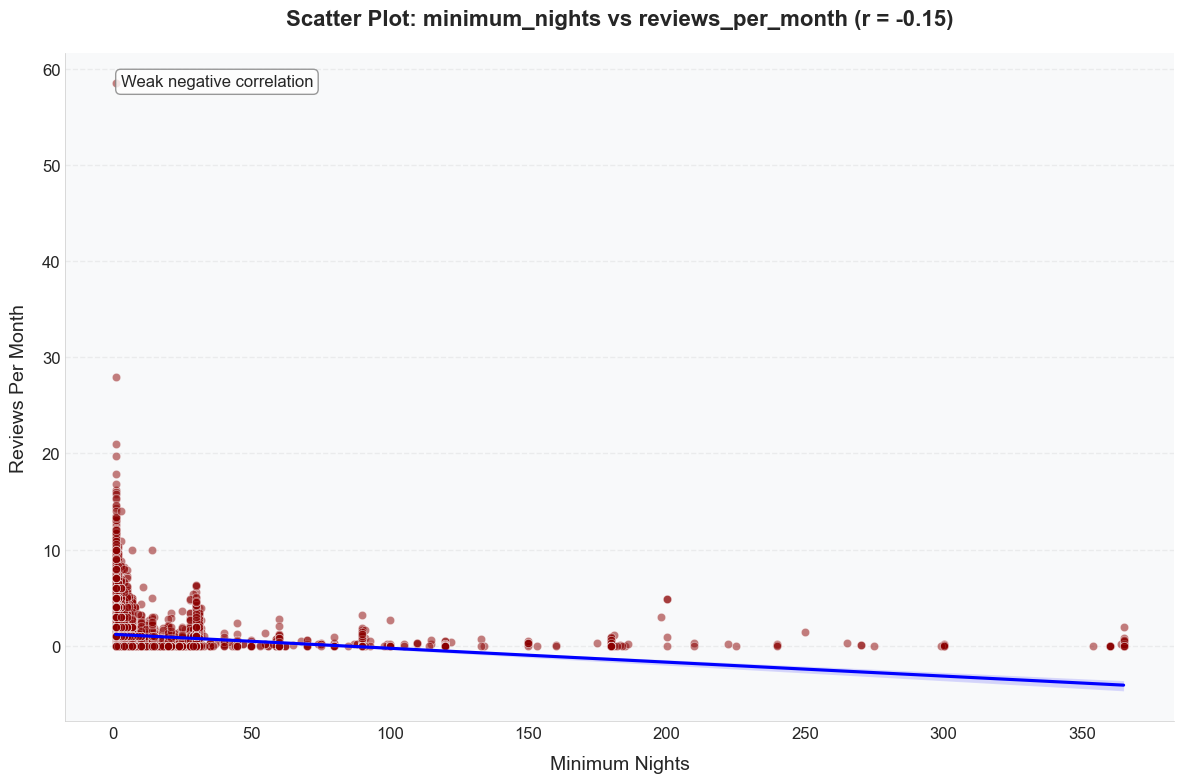


Interpretation of Correlation Analysis:
----------------------------------------
The strongest positive correlation (0.59) is between number_of_reviews and reviews_per_month.
This suggests that as number_of_reviews increases, reviews_per_month tends to increase as well.

The strongest negative correlation (-0.15) is between minimum_nights and reviews_per_month.
This suggests that as minimum_nights increases, reviews_per_month tends to decrease.


In [81]:
def analyze_and_visualize_correlations(dataframe):
    """
    Calculates a Pearson correlation matrix for selected numeric features,
    displays a heatmap, and identifies the pairs with the most positive
    and most negative correlations.

    Parameters:
        dataframe (pandas.DataFrame): Cleaned DataFrame of Airbnb listings.

    Returns:
        pandas.DataFrame: The correlation matrix.
    """
    print("\n--- Task 3: Pairwise Pearson Correlation Analysis ---")

    # Select relevant numeric columns for correlation analysis
    # We choose these columns as they represent key quantitative aspects of Airbnb listings
    selected_numeric_columns = [
        'price',  # Cost per night
        'minimum_nights',  # Minimum stay duration
        'number_of_reviews',  # Total review count
        'reviews_per_month',  # Review frequency
        'calculated_host_listings_count',  # Number of listings by the same host
        'availability_365'  # Days available per year
    ]

    # Calculate Pearson correlation coefficients between all pairs
    correlation_matrix = dataframe[selected_numeric_columns].corr(method='pearson')

    # Display the correlation matrix with gradient styling for better readability
    print("\nCorrelation Matrix (Pearson):")
    display(correlation_matrix.style.background_gradient(cmap='coolwarm', axis=None).format("{:.2f}"))

    # Create a heatmap visualization of the correlation matrix
    plt.figure(figsize=(14, 12))
    ax = sns.heatmap(
        correlation_matrix,
        annot=True,  # Show correlation values
        cmap='coolwarm',  # Red-blue color scheme (negative to positive)
        fmt='.2f',  # Format to 2 decimal places
        linewidths=0.5,  # Add grid lines
        cbar_kws={'label': 'Correlation Coefficient'}  # Add colorbar label
    )

    # Style the plot with appropriate title and layout
    style_plot(ax, title='Correlation Heatmap for Selected Numerical Features')
    plt.tight_layout()
    plt.show()

    # Find the strongest positive and negative correlations
    # First flatten the matrix and remove self-correlations (which are always 1.0)
    flattened_correlations = correlation_matrix.unstack()
    flattened_correlations = flattened_correlations[flattened_correlations < 1.0]

    # Identify the most positive correlation pair
    highest_correlation_value = flattened_correlations.max()
    highest_correlation_pair = flattened_correlations.idxmax()

    # Identify the most negative correlation pair
    lowest_correlation_value = flattened_correlations.min()
    lowest_correlation_pair = flattened_correlations.idxmin()

    # Print the findings
    print(
        f"\nMost Positive Correlation: {highest_correlation_pair[0]} and {highest_correlation_pair[1]} = {highest_correlation_value:.2f}")
    print(
        f"Most Negative Correlation: {lowest_correlation_pair[0]} and {lowest_correlation_pair[1]} = {lowest_correlation_value:.2f}")

    # Create a scatter plot to visualize the relationship between the most correlated features
    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(
        x=highest_correlation_pair[0],
        y=highest_correlation_pair[1],
        data=dataframe,
        alpha=0.5,  # Add transparency to handle overlapping points
        color='navy'  # Choose a professional color
    )

    # Add a trend line to highlight the correlation
    sns.regplot(
        x=highest_correlation_pair[0],
        y=highest_correlation_pair[1],
        data=dataframe,
        scatter=False,
        line_kws={"color": "red"}
    )

    # Style the scatter plot
    style_plot(
        ax,
        title=f'Scatter Plot: {highest_correlation_pair[0]} vs {highest_correlation_pair[1]} (r = {highest_correlation_value:.2f})',
        xlabel=highest_correlation_pair[0].replace('_', ' ').title(),
        ylabel=highest_correlation_pair[1].replace('_', ' ').title()
    )

    # Add annotation explaining the correlation
    correlation_interpretation = "Strong positive correlation" if highest_correlation_value > 0.7 else \
        "Moderate positive correlation" if highest_correlation_value > 0.3 else \
            "Weak positive correlation"
    plt.annotate(
        correlation_interpretation,
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )

    plt.tight_layout()
    plt.show()

    # Also create a scatter plot for the most negative correlation
    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(
        x=lowest_correlation_pair[0],
        y=lowest_correlation_pair[1],
        data=dataframe,
        alpha=0.5,
        color='darkred'
    )

    # Add a trend line
    sns.regplot(
        x=lowest_correlation_pair[0],
        y=lowest_correlation_pair[1],
        data=dataframe,
        scatter=False,
        line_kws={"color": "blue"}
    )

    # Style the scatter plot
    style_plot(
        ax,
        title=f'Scatter Plot: {lowest_correlation_pair[0]} vs {lowest_correlation_pair[1]} (r = {lowest_correlation_value:.2f})',
        xlabel=lowest_correlation_pair[0].replace('_', ' ').title(),
        ylabel=lowest_correlation_pair[1].replace('_', ' ').title()
    )

    # Add annotation explaining the correlation
    neg_correlation_interpretation = "Strong negative correlation" if lowest_correlation_value < -0.7 else \
        "Moderate negative correlation" if lowest_correlation_value < -0.3 else \
            "Weak negative correlation"
    plt.annotate(
        neg_correlation_interpretation,
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )

    plt.tight_layout()
    plt.show()

    # Provide a brief interpretation of the correlation findings
    print("\nInterpretation of Correlation Analysis:")
    print("----------------------------------------")
    print(
        f"The strongest positive correlation ({highest_correlation_value:.2f}) is between {highest_correlation_pair[0]} and {highest_correlation_pair[1]}.")
    print(
        f"This suggests that as {highest_correlation_pair[0]} increases, {highest_correlation_pair[1]} tends to increase as well.")
    print(
        f"\nThe strongest negative correlation ({lowest_correlation_value:.2f}) is between {lowest_correlation_pair[0]} and {lowest_correlation_pair[1]}.")
    print(
        f"This suggests that as {lowest_correlation_pair[0]} increases, {lowest_correlation_pair[1]} tends to decrease.")

    return correlation_matrix


# Execute the function
correlation_matrix = analyze_and_visualize_correlations(final_cleaned_new_york_city_airbnb_data)


## Task 4a: Visualizing Listings by Borough

In this task, I created several visualizations to explore the **geographic distribution** of Airbnb listings across New York City boroughs using `latitude`, `longitude`, and `neighbourhood_group`.

### What I Did:
- Cleaned the dataset by filtering out listings with missing location or borough data.
- Used a scatter plot to map each listing by coordinates.
  - Each borough is **color-coded** using a distinct, high-contrast palette.
  - A **summary box** annotates total listings per borough.
  - Added a **north arrow** and an approximate **scale bar** (5 km).
- Supplemented the map with a **pie chart** showing the percentage of listings per borough.

### Key Features:
- **Boroughs Mapped**: Manhattan, Brooklyn, Queens, Bronx, Staten Island
- **Visual Enhancements**:
  - Custom legend with borough counts
  - Informative tooltips and label styling
  - Background color and subtle gridlines

### Optional Additions:
- The map includes a **summary annotation** with borough-wise breakdowns and total count.
- A **pie chart** visualizes proportional listing distribution.

### Benefits:
These plots clearly show that:
- **Manhattan** and **Brooklyn** have the highest listing concentrations.
- **Queens** and **Bronx** have moderate density.
- **Staten Island** has the fewest listings, mostly around its northern edge.


--- Task 4a: Map of Listings by Borough ---


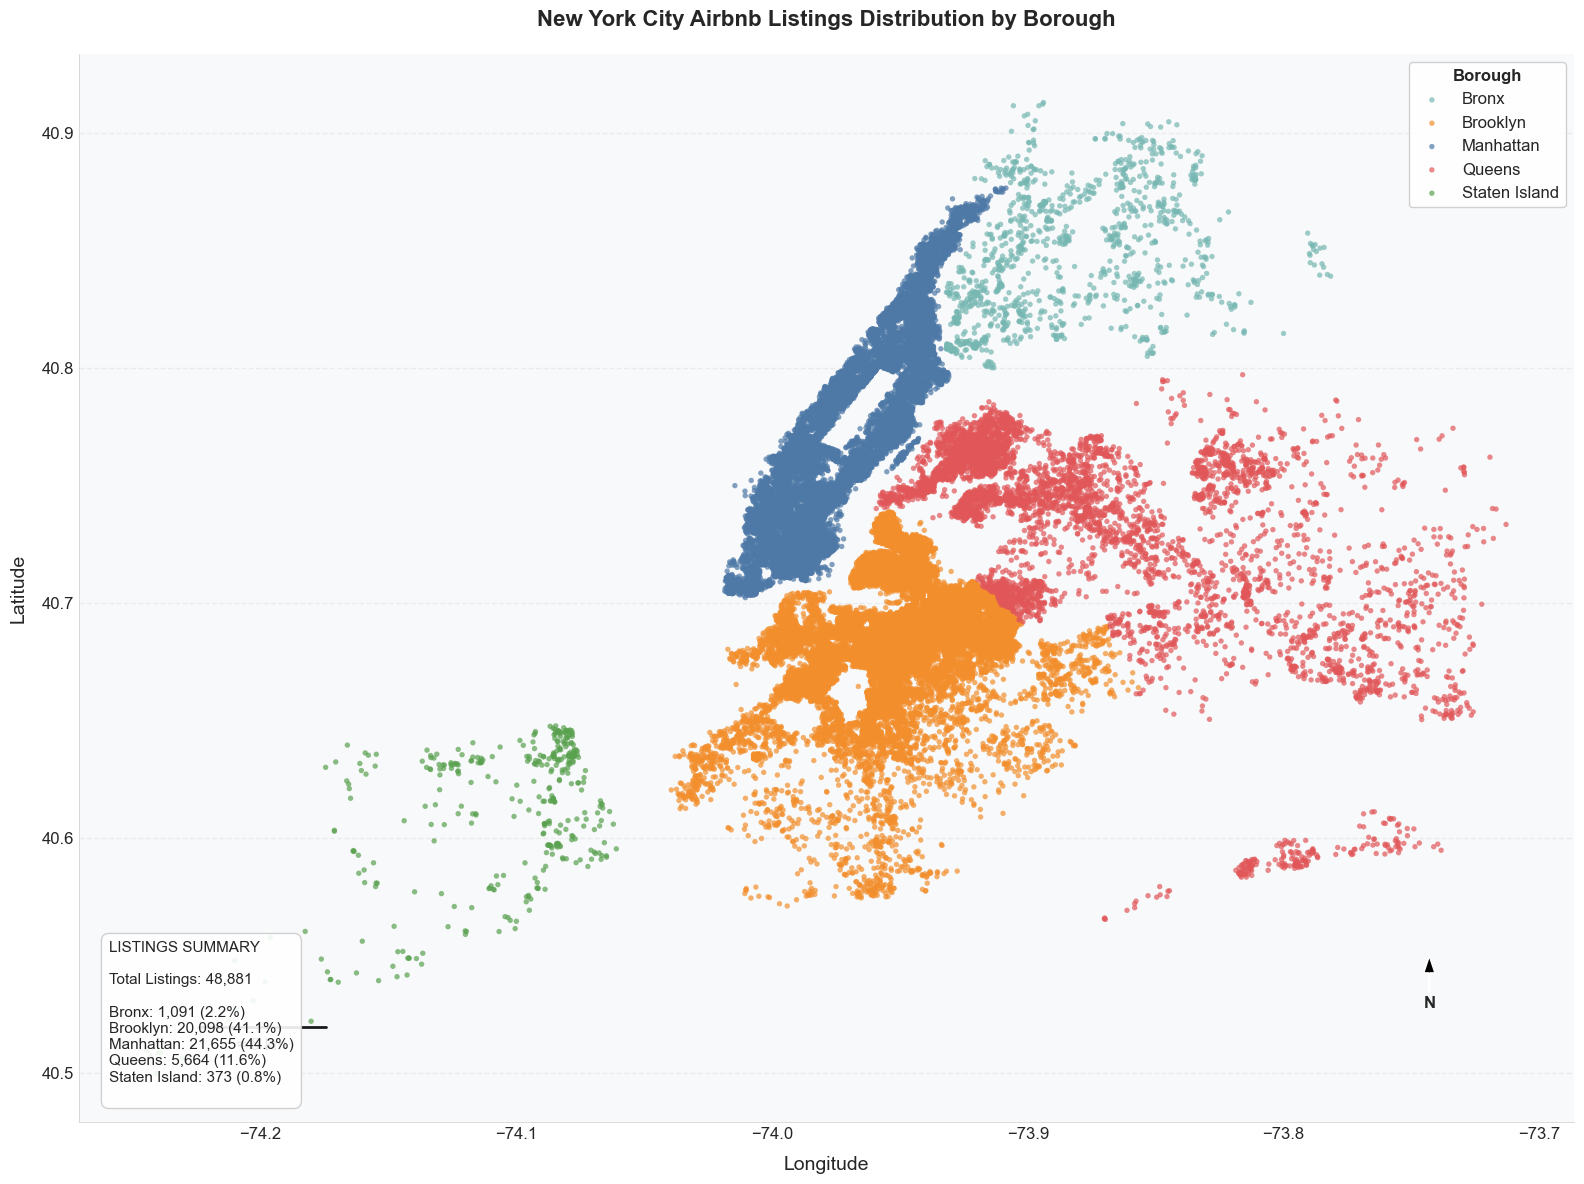


--- Pie Chart: Listing Distribution by Borough ---


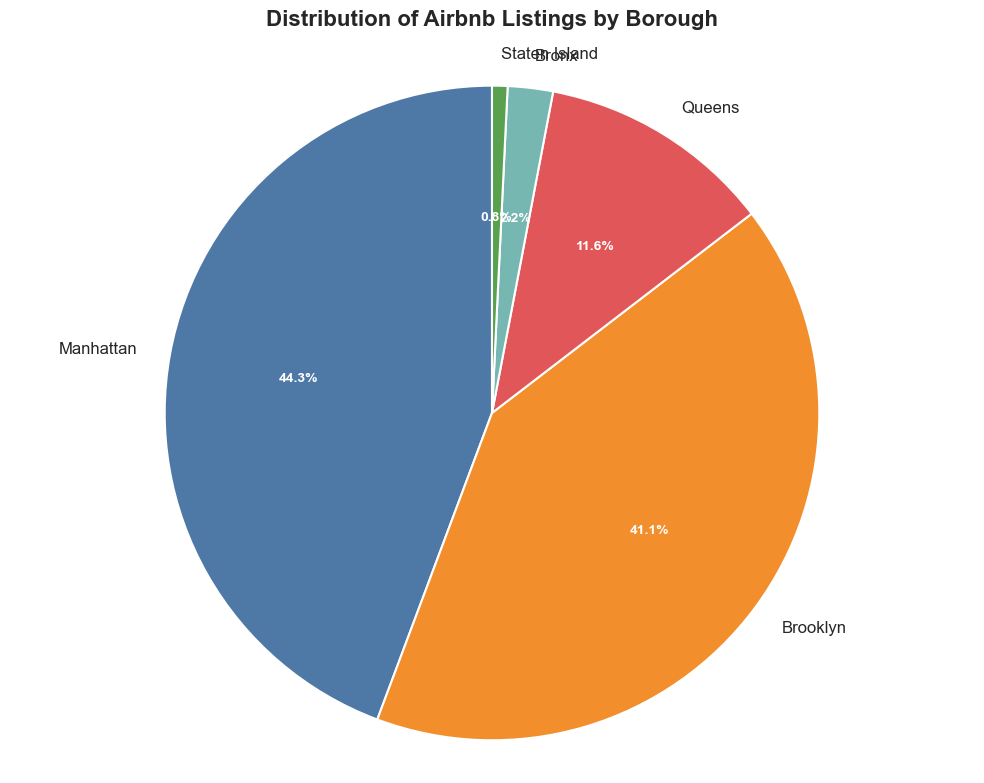

In [84]:
def visualize_listings_distribution_by_borough(dataframe):
    """
    Creates enhanced visualizations of Airbnb listing distribution across NYC boroughs:
    - Scatter map by borough
    - Pie chart of listing distribution

    Parameters:
        dataframe (pandas.DataFrame): Cleaned DataFrame of Airbnb listings.
    """
    print("\n--- Task 4a: Map of Listings by Borough ---")

    # Set up base plot
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.set_facecolor('#f0f0f0')

    # Color palette
    borough_colors = {
        'Manhattan': '#4e79a7',
        'Brooklyn': '#f28e2c',
        'Queens': '#e15759',
        'Bronx': '#76b7b2',
        'Staten Island': '#59a14f'
    }

    unique_boroughs = sorted(dataframe['neighbourhood_group'].unique())

    for borough in unique_boroughs:
        subset = dataframe[dataframe['neighbourhood_group'] == borough]
        ax.scatter(
            subset['longitude'],
            subset['latitude'],
            c=borough_colors.get(borough, '#000000'),
            label=borough,
            alpha=0.7,
            s=15,
            edgecolors='none'
        )

    # Plot styling
    style_plot(ax,
               title='New York City Airbnb Listings Distribution by Borough',
               xlabel='Longitude',
               ylabel='Latitude')

    # Legend
    legend = ax.legend(title='Borough', loc='upper right', frameon=True,
                       framealpha=0.9, edgecolor='#cccccc')
    legend.get_title().set_fontweight('bold')

    # Scale bar
    scale_bar_length = 0.05
    ax.plot([dataframe['longitude'].min() + 0.02, dataframe['longitude'].min() + 0.02 + scale_bar_length],
            [dataframe['latitude'].min() + 0.02, dataframe['latitude'].min() + 0.02],
            'k-', linewidth=2)
    ax.text(dataframe['longitude'].min() + 0.02 + scale_bar_length / 2,
            dataframe['latitude'].min() + 0.01,
            '≈ 5 km',
            horizontalalignment='center')

    # Listing summary box
    borough_counts = dataframe['neighbourhood_group'].value_counts()
    summary_text = f"LISTINGS SUMMARY\n\nTotal Listings: {len(dataframe):,}\n\n"
    for borough in unique_boroughs:
        count = borough_counts.get(borough, 0)
        percentage = count / len(dataframe) * 100
        summary_text += f"{borough}: {count:,} ({percentage:.1f}%)\n"

    props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='#cccccc')
    ax.text(0.02, 0.02, summary_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='bottom', bbox=props, family='sans-serif')

    # North arrow
    arrow_x, arrow_y = dataframe['longitude'].max() - 0.03, dataframe['latitude'].min() + 0.05
    ax.annotate('N', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y - 0.02),
                arrowprops=dict(facecolor='black', width=1, headwidth=8),
                ha='center', va='center', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Pie chart
    print("\n--- Pie Chart: Listing Distribution by Borough ---")
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111)
    wedges, texts, autotexts = ax.pie(
        borough_counts,
        labels=borough_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=[borough_colors.get(b, '#000000') for b in borough_counts.index],
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
    )

    for text in texts:
        text.set_fontsize(12)
    for autotext in autotexts:
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')
        autotext.set_color('white')

    style_plot(ax, title='Distribution of Airbnb Listings by Borough')
    ax.axis('equal')
    plt.tight_layout()
    plt.show()


# Call Function
visualize_listings_distribution_by_borough(final_cleaned_new_york_city_airbnb_data)

## Task 4b: Map of Listings by Price (Below $1000)

In this task, I created a set of visualizations to explore the **distribution of Airbnb prices** under \$1000 across New York City. This helps uncover spatial and borough-level pricing patterns.

### What I Did:
- **Filtered** the dataset to include only listings with price < \$1000 (99.4% of all listings).
- Generated three main visualizations:
  1. **Geographic Scatter Plot**
     - Each dot represents a listing, color-coded by price.
     - A **custom color gradient** (blue to red) highlights price intensity.
     - Added a **summary box** showing average/median prices by borough.
  2. **Boxplot + Swarmplot**
     - Displays price distribution within each borough.
     - Overlayed with a random sample of 5000 listings for readability.
     - Mean prices are marked in red.
  3. **Histogram with KDE per Borough**
     - One plot per borough.
     - Each includes **mean and median lines** to highlight skewness.

### Key Takeaways:
- **Manhattan** remains the most expensive borough overall, even with high-end listings removed.
- **Bronx** and **Staten Island** have the lowest average prices.
- **Price distribution is right-skewed** in every borough, with a few higher-end listings pulling the average up.



--- Task 4b: Map of Listings by Price (Below $1000) ---
Number of listings under $1000: 48,583
Percentage of total listings: 99.4%


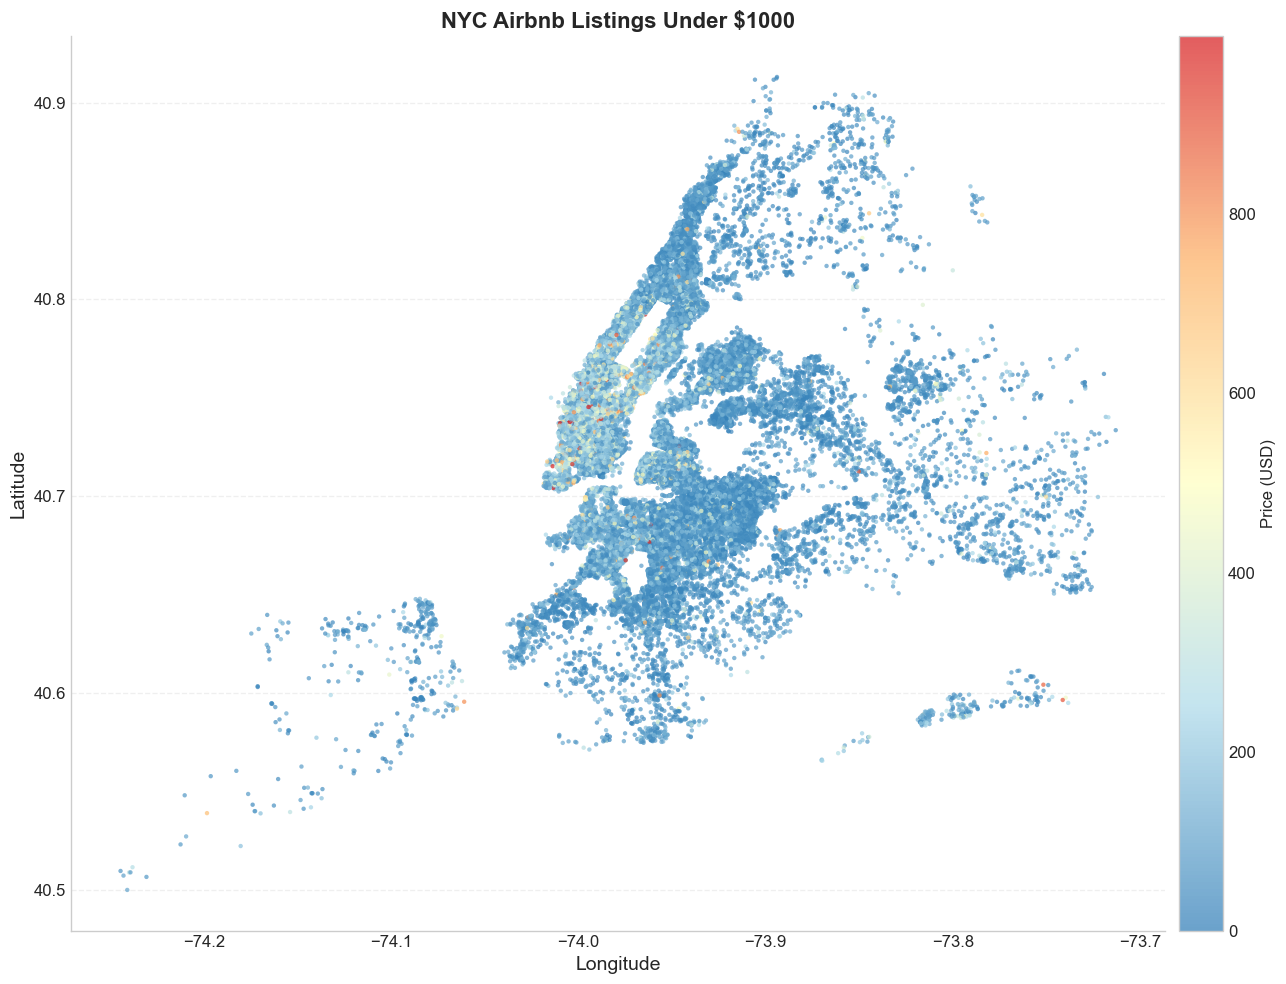

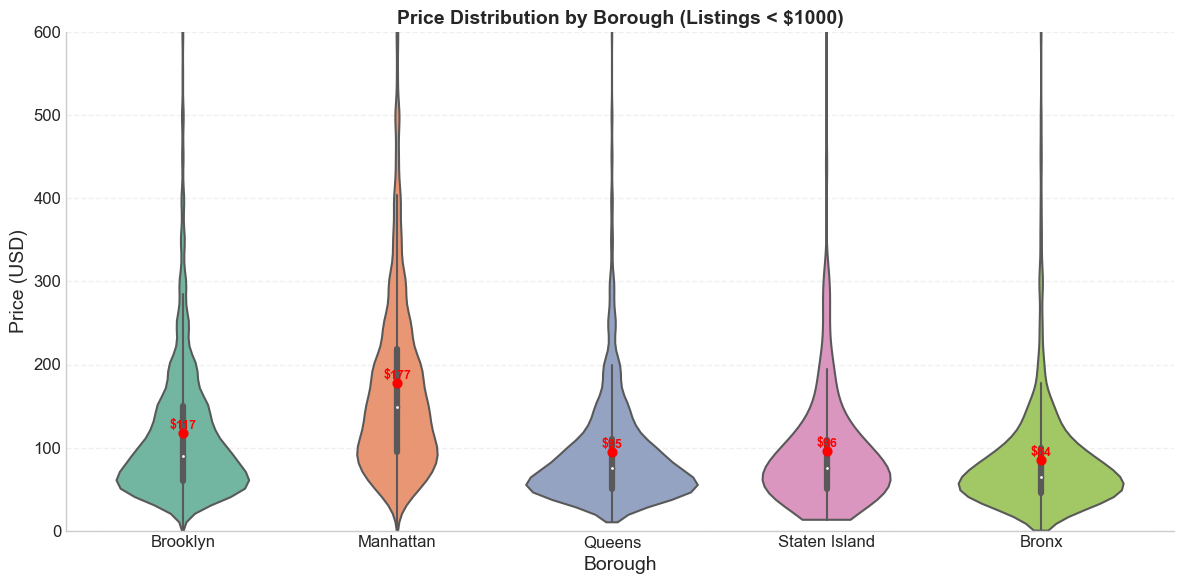

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

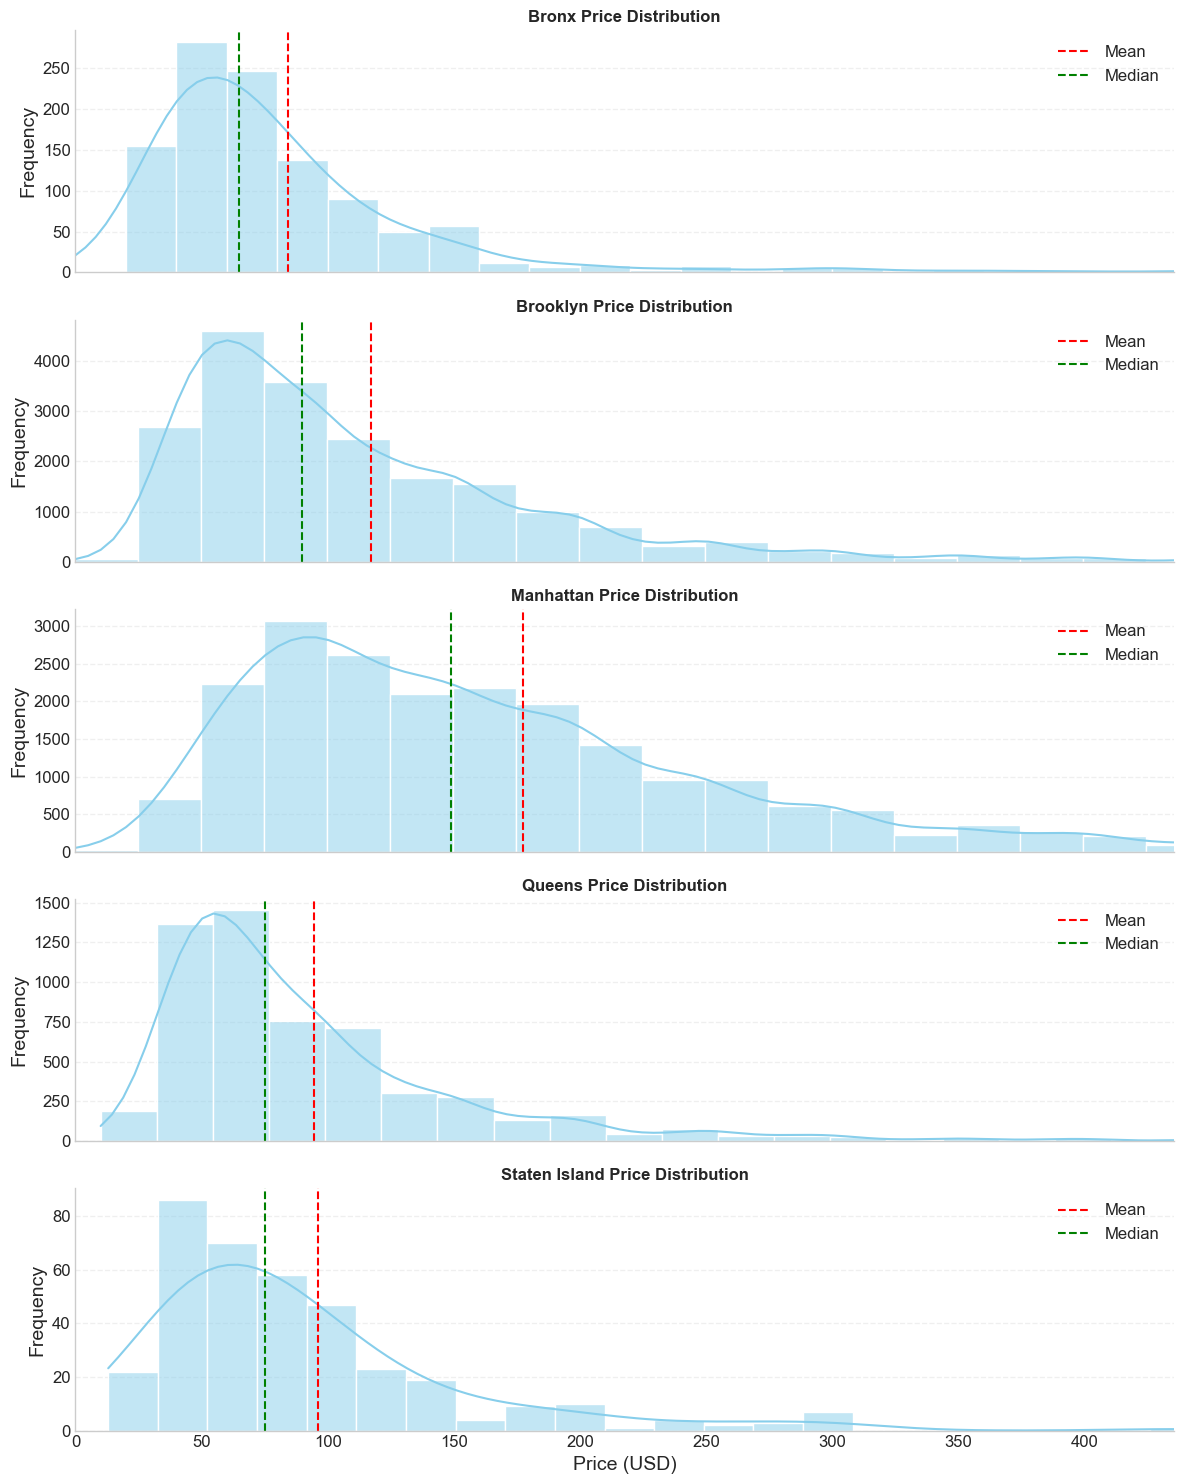

In [89]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import warnings


def visualize_price_distribution_map(dataframe, price_threshold=1000):
    """
    Visualizes Airbnb listings under a given price threshold using:
    - Scatter map color-coded by price
    - Violin + box plot for borough-level distributions
    - Histograms with mean and median for each borough
    """
    print(f"\n--- Task 4b: Map of Listings by Price (Below ${price_threshold}) ---")
    warnings.filterwarnings("ignore", category=UserWarning)

    affordable = dataframe[dataframe['price'] < price_threshold]
    print(f"Number of listings under ${price_threshold}: {len(affordable):,}")
    print(f"Percentage of total listings: {(len(affordable) / len(dataframe) * 100):.1f}%")

    # ----- SCATTER MAP -----
    fig, ax = plt.subplots(figsize=(14, 10))
    cmap = mpl.colors.LinearSegmentedColormap.from_list("price_gradient",
                                                        ["#2c7bb6", "#abd9e9", "#ffffbf", "#fdae61", "#d7191c"])

    scatter = ax.scatter(
        affordable['longitude'], affordable['latitude'],
        c=affordable['price'], cmap=cmap,
        alpha=0.7, s=10, edgecolors='none'
    )
    cbar = plt.colorbar(scatter, ax=ax, pad=0.01)
    cbar.set_label('Price (USD)', fontsize=12)

    ax.set_title(f'NYC Airbnb Listings Under ${price_threshold}', fontsize=16, weight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.tight_layout()
    plt.show()

    # ----- VIOLIN + BOX PLOT -----
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(
        x='neighbourhood_group', y='price', data=affordable,
        inner='box', palette='Set2', cut=0
    )

    means = affordable.groupby('neighbourhood_group')['price'].mean()
    for i, tick in enumerate(ax.get_xticklabels()):
        b = tick.get_text()
        ax.scatter(i, means[b], color='red', s=40, zorder=10)
        ax.text(i, means[b] + 5, f"${means[b]:.0f}", color='red', ha='center', fontsize=9, weight='bold')

    ax.set_title('Price Distribution by Borough (Listings < $1000)', fontsize=14, weight='bold')
    ax.set_ylabel('Price (USD)')
    ax.set_xlabel('Borough')
    ax.set_ylim(0, affordable['price'].quantile(0.99))
    sns.despine()
    plt.tight_layout()
    plt.show()

    # ----- HISTOGRAMS -----
    boroughs = affordable['neighbourhood_group'].unique()
    borough_stats = affordable.groupby('neighbourhood_group')['price'].agg(['mean', 'median'])
    fig, axes = plt.subplots(len(boroughs), 1, figsize=(12, 3 * len(boroughs)), sharex=True)

    for i, b in enumerate(sorted(boroughs)):
        ax = axes[i] if len(boroughs) > 1 else axes
        subset = affordable[affordable['neighbourhood_group'] == b]['price']
        sns.histplot(subset, bins=40, kde=True, ax=ax, color='skyblue')

        ax.axvline(x=borough_stats.loc[b, 'mean'], color='red', linestyle='--', label='Mean')
        ax.axvline(x=borough_stats.loc[b, 'median'], color='green', linestyle='--', label='Median')

        ax.set_title(f'{b} Price Distribution', fontsize=12, weight='bold')
        ax.set_ylabel('Frequency')
        ax.legend()

        ax.set_xlim(0, subset.quantile(0.99))

    axes[-1].set_xlabel('Price (USD)')
    plt.tight_layout()
    plt.show()


visualize_price_distribution_map(final_cleaned_new_york_city_airbnb_data)


## Task 5: Word Cloud of Airbnb Listing Titles

In this task, I explored the **text data** within Airbnb listing titles to uncover the most frequently used words. Word clouds are a powerful visual tool for summarizing large amounts of textual information by highlighting word frequency and prominence.

### What I Did:
- Extracted the `name` field from all Airbnb listings.
- Cleaned the text by:
  - Lowercasing all letters
  - Removing non-alphabetic characters (e.g., punctuation)
  - Removing common stopwords (e.g., *in*, *on*, *the*)
- Counted the frequency of each word and printed the **Top 20 most common words**.
- Generated a **custom-colored word cloud** using a horizontal rectangular layout and a clean white background.
- Added annotations and aesthetic enhancements for professional visual presentation.

### Dataset Summary:
- **Total Listings Analyzed**: 48,881
- **Titles Present**: 100.0% (no missing titles)
- **Average Title Length**: ~37 characters
- **Total Words Processed**: 277,845
- **Unique Words (after cleaning)**: 9,035

### Top 20 Most Frequent Words:
| Rank | Word          | Occurrences |
|------|---------------|-------------|
| 1    | room          | 10,100      |
| 2    | bedroom       | 8,042       |
| 3    | private       | 7,176       |
| 4    | apartment     | 6,704       |
| 5    | cozy          | 5,006       |
| ...  | ...           | ...         |
| 20   | large         | 2,046       |

### Key Takeaways:
- **Descriptive terms** like "cozy", "private", and "spacious" dominate listings, reflecting marketing emphasis.
- **Geographic keywords** such as "Manhattan", "Brooklyn", "Williamsburg", and "Village" are frequently mentioned, helping guests quickly identify location.
- The dominance of "room", "apt", and "studio" suggests that many listings are **partial or shared spaces**, not full apartments.

This word cloud offers an engaging snapshot of how hosts title their listings and what themes or selling points are emphasized in the competitive NYC Airbnb market.


                   WORD CLOUD ANALYSIS: AIRBNB LISTING TITLES                   

DATASET OVERVIEW:
  • Total listings analyzed: 48,881
  • Listings with titles: 48,881 (100.0%)
  • Average title length: 36.9 characters

SAMPLE LISTING TITLES:
  1. Masterful bedroom & private bathroom in Astoria
  2. Sunny Practical Apt in Williamsburg BK!!!
  3. Times Square NYC
  4. Brownstone Studio
  5. Gorgeous Bedroom in Manhattan Midtown West

TEXT PROCESSING METRICS:
  • Raw text size: 1,852,899 characters
  • Cleaned text size: 1,776,794 characters
  • Total words analyzed: 277,845
  • Unique words: 9,035

TOP 20 MOST FREQUENT WORDS:
   1. room            10100 occurrences
   2. bedroom          8042 occurrences
   3. private          7176 occurrences
   4. apartment        6704 occurrences
   5. cozy             5006 occurrences
   6. apt              4634 occurrences
   7. brooklyn         4055 occurrences
   8. studio           3998 occurrences
   9. spacious         3729 occurrences
  10.

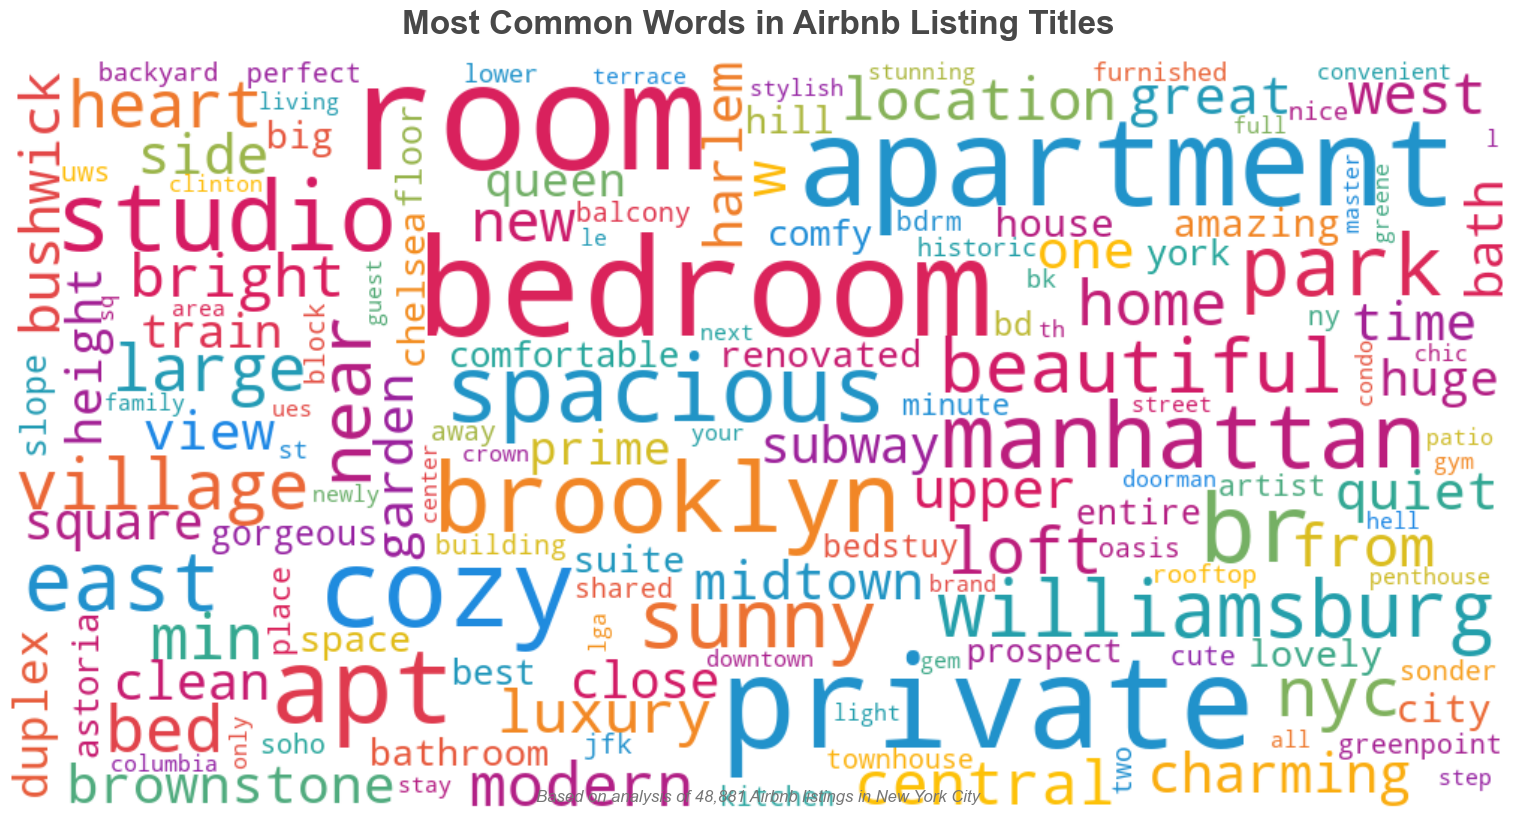

In [94]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import re
from collections import Counter
import numpy as np
from PIL import Image
import matplotlib.colors as mcolors


def create_and_show_word_cloud(df):
    """
    Generates an aesthetically pleasing word cloud from Airbnb listing titles with
    additional data analysis on word frequency.

    Parameters:
        df (pandas.DataFrame): Cleaned Airbnb DataFrame

    Returns:
        None
    """
    print("\n" + "=" * 80)
    print("WORD CLOUD ANALYSIS: AIRBNB LISTING TITLES".center(80))
    print("=" * 80)

    # Basic statistics
    total_listings = len(df)
    listings_with_titles = df['name'].notna().sum()
    avg_title_length = df['name'].dropna().str.len().mean()

    print(f"\nDATASET OVERVIEW:")
    print(f"  • Total listings analyzed: {total_listings:,}")
    print(f"  • Listings with titles: {listings_with_titles:,} ({listings_with_titles / total_listings:.1%})")
    print(f"  • Average title length: {avg_title_length:.1f} characters")

    print(f"\nSAMPLE LISTING TITLES:")
    for i, title in enumerate(df['name'].dropna().sample(5, random_state=42).values, 1):
        print(f"  {i}. {title}")

    # Concatenate all listing titles into a single string
    combined_text = " ".join(df['name'].dropna().astype(str).str.lower())

    # Remove non-letter characters and common stop words
    stop_words = {'the', 'and', 'in', 'on', 'at', 'to', 'for', 'with', 'a', 'an', 'of', 'by'}
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', combined_text)

    # Count word frequencies
    words = cleaned_text.split()
    word_counts = Counter(word for word in words if word not in stop_words and len(word) > 2)
    top_words = word_counts.most_common(20)

    print(f"\nTEXT PROCESSING METRICS:")
    print(f"  • Raw text size: {len(combined_text):,} characters")
    print(f"  • Cleaned text size: {len(cleaned_text):,} characters")
    print(f"  • Total words analyzed: {len(words):,}")
    print(f"  • Unique words: {len(word_counts):,}")

    print(f"\nTOP 20 MOST FREQUENT WORDS:")
    for i, (word, count) in enumerate(top_words, 1):
        print(f"  {i:2d}. {word:15s} {count:5d} occurrences")

    # Create a custom color gradient
    colors = ["#1E88E5", "#26A69A", "#FFC107", "#D81B60", "#8E24AA"]
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_airbnb", colors)

    # Create a mask for the word cloud (optional)
    # You can replace this with any mask image you prefer
    mask = np.ones((500, 1000), dtype=np.int8)

    # Create word cloud with enhanced aesthetics
    wordcloud = WordCloud(
        width=1000,
        height=500,
        background_color='white',
        colormap=custom_cmap,
        max_words=150,
        collocations=False,
        contour_width=1,
        contour_color='#7f7f7f',
        font_path=None,  # Add a custom font path if available
        mask=mask,
        min_font_size=10,
        max_font_size=100,
        random_state=42,
        prefer_horizontal=0.9,
        relative_scaling=0.5,
        stopwords=stop_words
    ).generate(cleaned_text)

    print("\nGENERATING WORD CLOUD VISUALIZATION...")

    # Plot with enhanced styling
    fig, ax = plt.subplots(figsize=(16, 8), facecolor='white')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    # Add a stylish title and subtitle
    plt.title("Most Common Words in Airbnb Listing Titles",
              fontsize=24, fontweight='bold', pad=20, color='#484848')

    # Add a footer with dataset info
    plt.figtext(0.5, 0.01, f"Based on analysis of {total_listings:,} Airbnb listings in New York City",
                ha="center", fontsize=12, fontstyle='italic', color='#767676')

    plt.tight_layout(pad=0)
    plt.savefig('airbnb_wordcloud.png', dpi=300, bbox_inches='tight')
    plt.show()


# Call the function
create_and_show_word_cloud(final_cleaned_new_york_city_airbnb_data)



## Task 6: Analyzing the Busiest Hosts in NYC

This analysis focuses on identifying and evaluating the **top 10 busiest Airbnb hosts** in New York City by number of listings. Metrics such as price, availability, and review patterns are explored to understand their hosting behavior.

### What I Did:
- Aggregated data by `host_id` and `host_name`
- Computed key statistics for each host:
  - Number of listings
  - Price range and average
  - Availability (days/year)
  - Reviews per month and total reviews
  - Dominant neighborhoods
- Created visualizations:
  - Bar chart of top hosts by listing count
  - Scatter plot of listings vs. average price
  - Availability and review comparison
  - Price range bars with mean and median indicators
  - Correlation heatmap of key host metrics
  - Stacked bar chart of listings by neighborhood group

### Key Findings:
- The **busiest host**, `Sonder (NYC)`, manages **327 listings**.
- The **majority of top hosts operate in Manhattan**.
- **Average price for top hosts** is **$210.08**, which is **37.6% higher** than the overall average of **$152.73**.
- **Top hosts have 150.5% higher availability**, suggesting a professional or business-like hosting style.
- Interestingly, their **reviews per month are 81.2% lower**, possibly due to longer stays or newer listings.

### Summary Insights:
1. The busiest hosts tend to operate in **Manhattan**.
2. They charge **higher prices** than the citywide average.
3. Their listings have **greater year-round availability**.
4. They tend to receive **fewer reviews per month**, which may reflect longer stays, fewer guests, or lower turnover.
5. These patterns align with **professional property management strategies**, distinguishing them from typical hosts.



=== Task 6: Analyzing the Busiest Hosts in NYC ===

Top 10 Hosts with the Highest Listing Counts:


host_id          host_name  total_listings   avg_price  median_price  \
34633  219517861       Sonder (NYC)             327  253.195719         228.0   
29395  107434423         Blueground             232  303.150862         302.5   
19564   30283594               Kara             121  277.528926         239.0   
31067  137358866             Kazuya             103   43.825243          41.0   
14428   16098958     Jeremy & Laura              96  208.958333         180.0   
12799   12243051             Sonder              96  213.031250         209.5   
25651   61391963  Corporate Housing              91  146.241758         142.0   
17081   22541573                Ken              87  215.436782         210.0   
33856  200380610            Pranjal              65  290.230769         250.0   
9727     7503643               Vida              52  149.192308         149.0   

       min_price  max_price  avg_availability  avg_reviews_per_month  \
34633        100        699        301.492355               1.215780   
29395        184        481        253.810345               0.026034   
19564        109       1170        313.421488               0.032562   
31067         24         76        196.475728               0.220194   
14428        117        550        292.322917               0.076042   
12799        125        377        276.614583               0.090104   
25651        109        200        241.923077               0.232747   
17081        149        289        312.172414               0.048851   
33856        150        600        338.030769               0.015385   
9727         129        199        297.711538               0.095385   

       total_reviews  avg_reviews_per_listing main_neighborhood_group  \
34633           1281                 3.917431               Manhattan   
29395             29                 0.125000               Manhattan   
19564             65                 0.537190               Manhattan   
31067             87                 0.844660                  Queens   
14428            138                 1.437500               Manhattan   
12799             43                 0.447917               Manhattan   
25651            417                 4.582418               Manhattan   
17081             55                 0.632184               Manhattan   
33856              1                 0.015385               Manhattan   
9727             242                 4.653846                Brooklyn   

                                           neighborhoods  
34633  Financial District, Murray Hill, Theater District  
29395                 Chelsea, Tribeca, Theater District  
19564          Hell's Kitchen, Midtown, Theater District  
31067                        Woodside, Sunnyside, Harlem  
14428           Upper West Side, Midtown, Hell's Kitchen  
12799               Financial District, Midtown, Chelsea  
25651                 Kips Bay, Midtown, Upper East Side  
17081                  Chelsea, Upper East Side, Midtown  
33856           Midtown, Upper East Side, Hell's Kitchen  
9727                                          Greenpoint

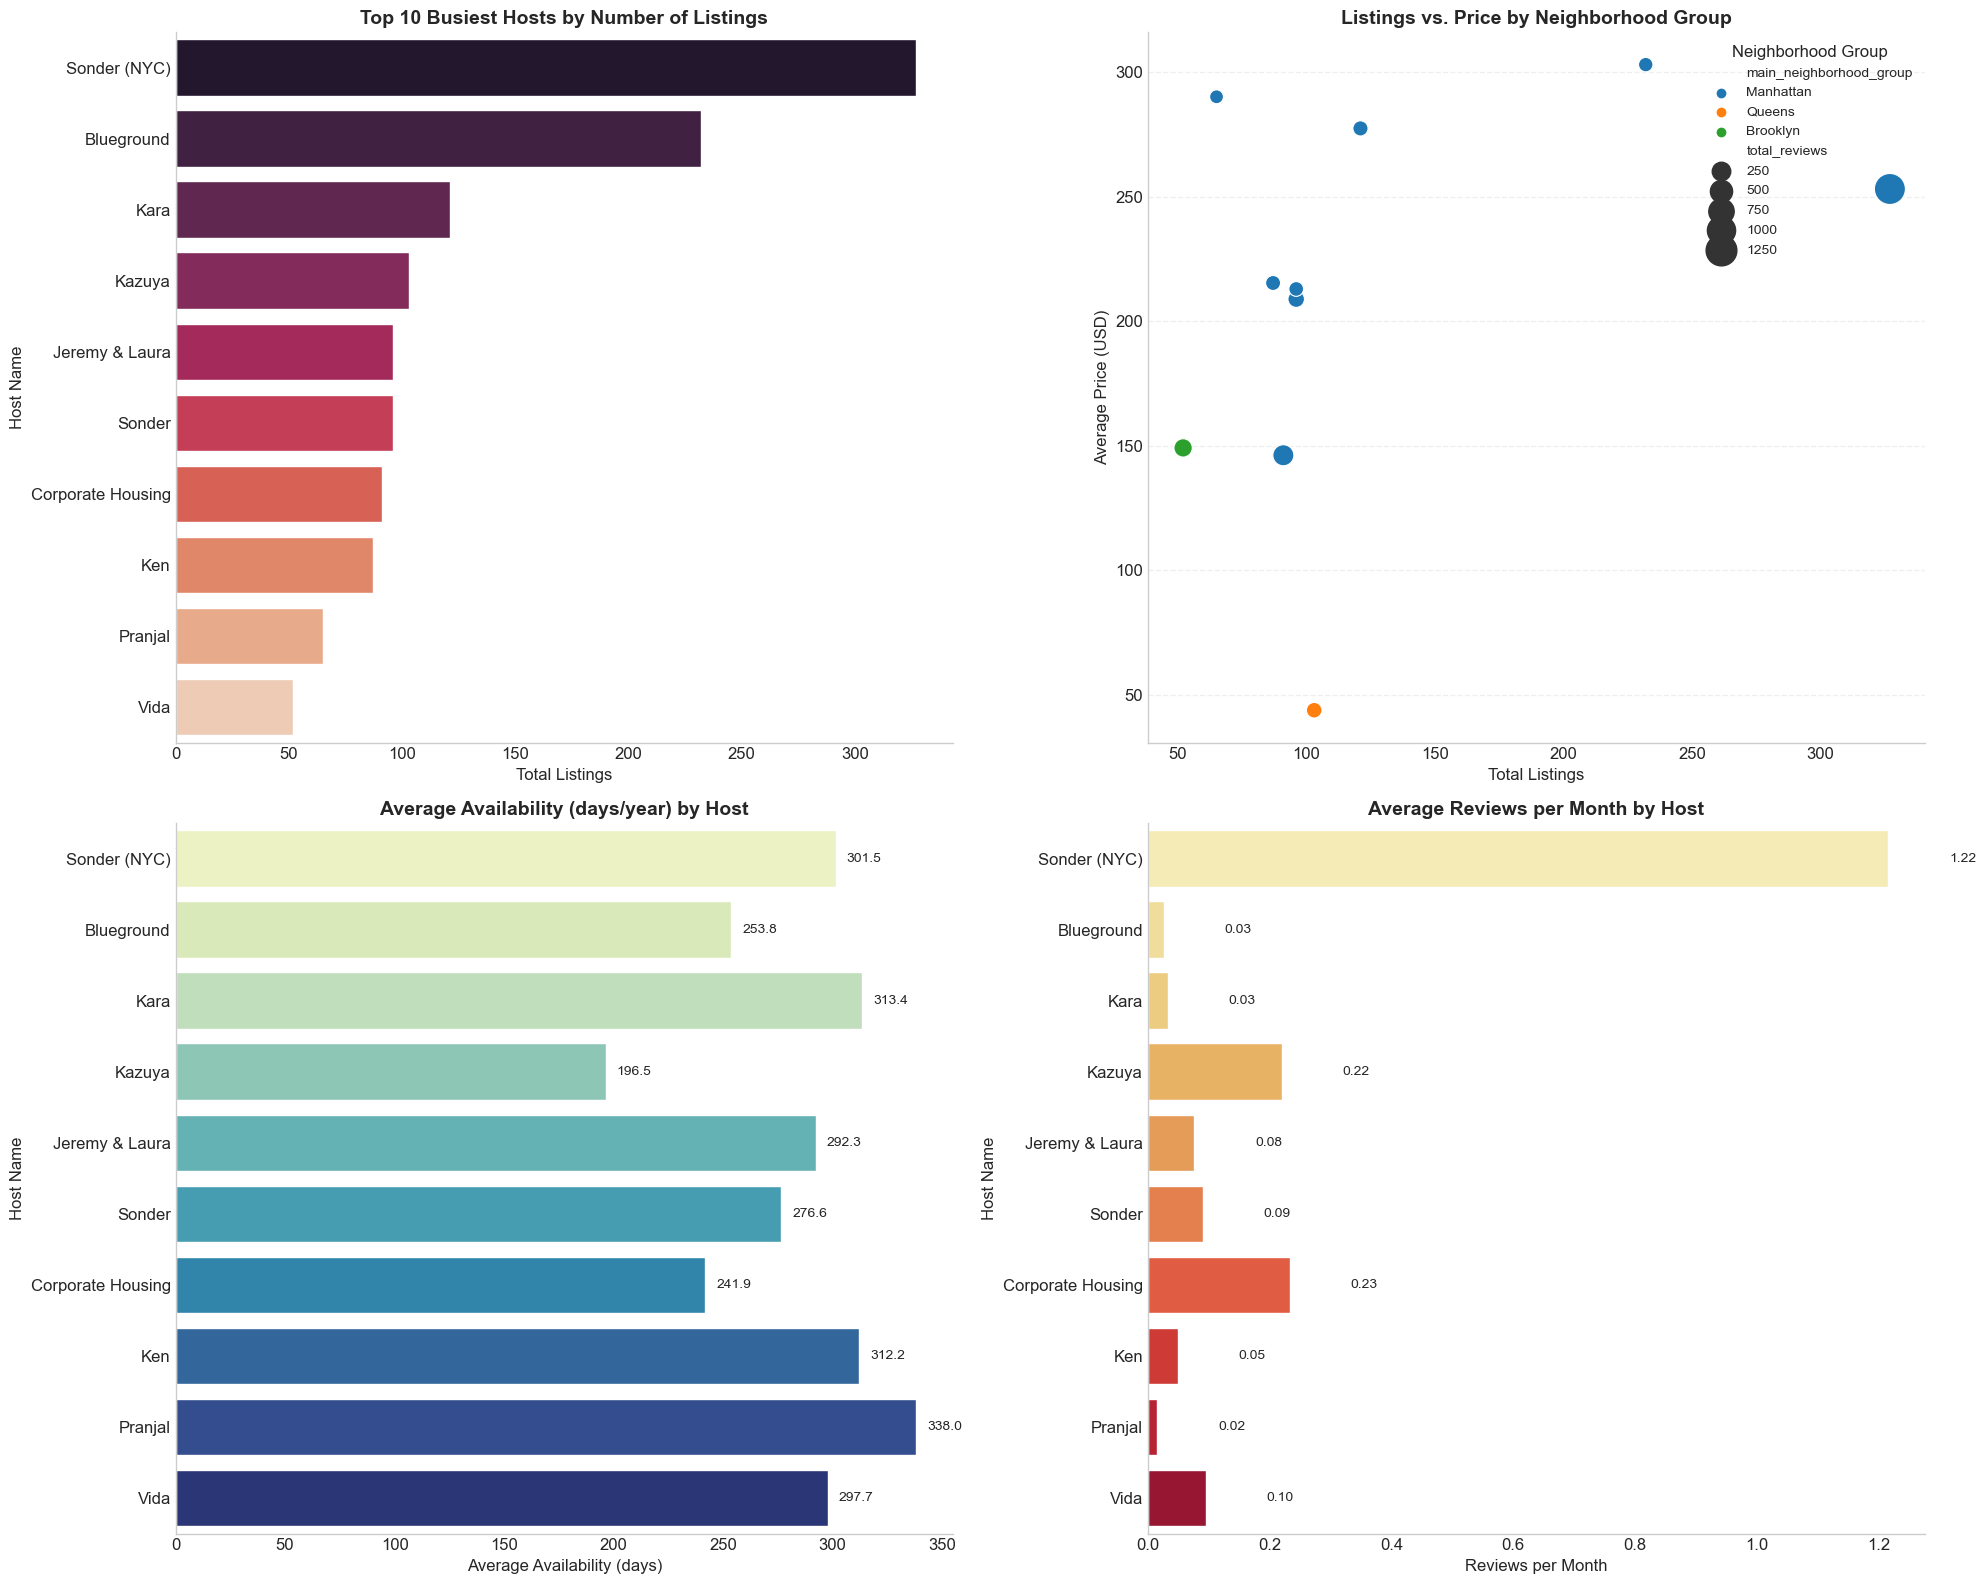

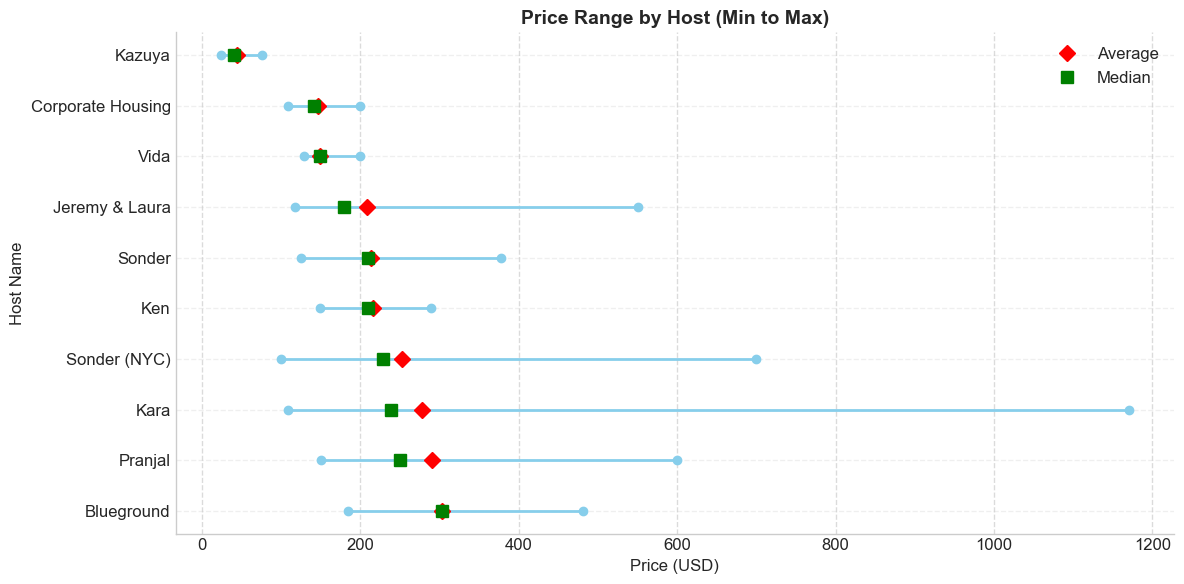

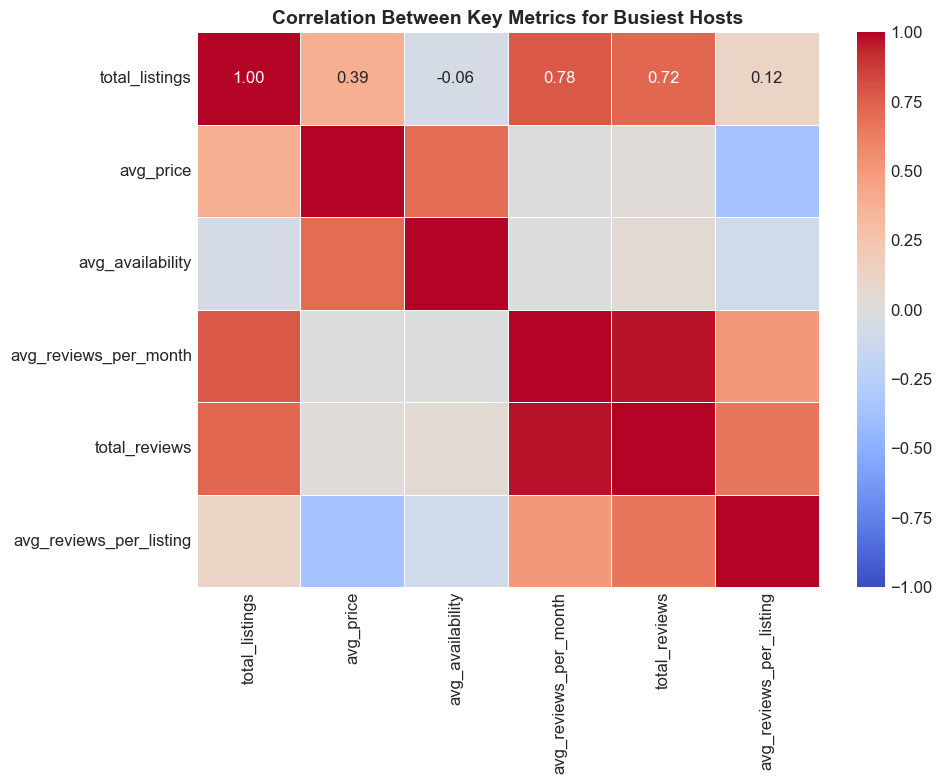

<Figure size 1400x800 with 0 Axes>

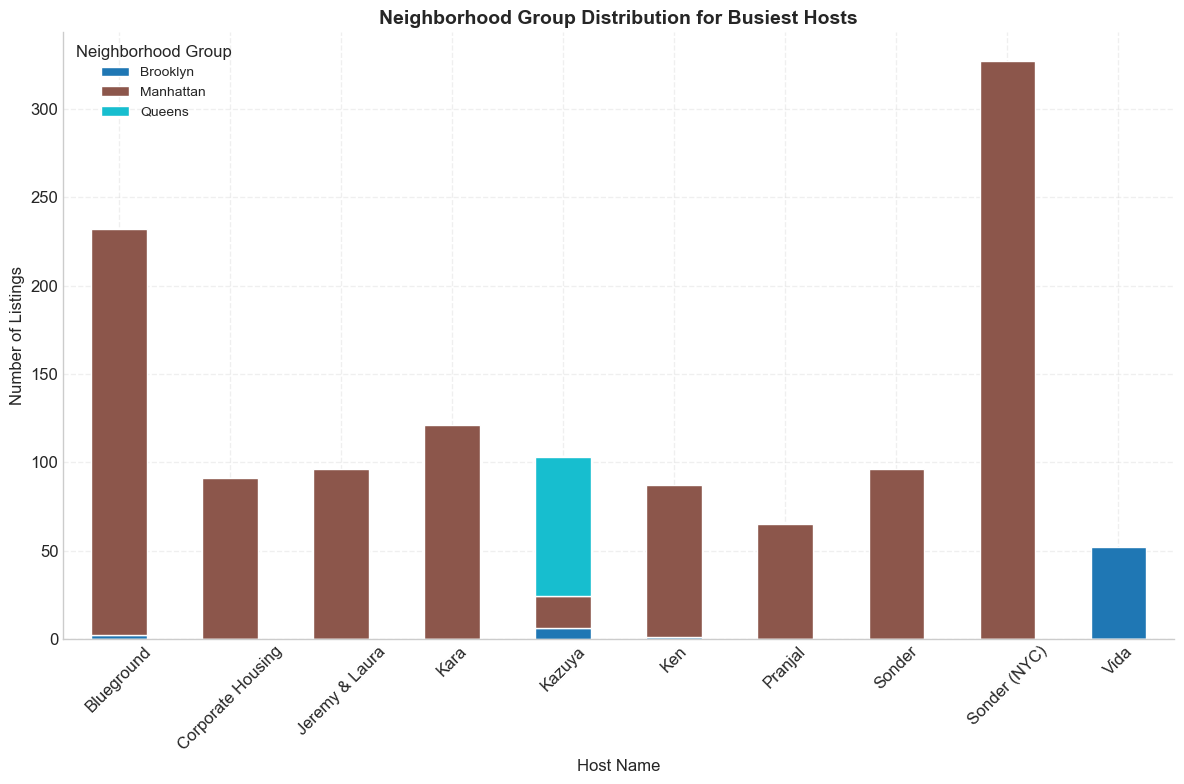


Analysis of Busiest Hosts in NYC

The top 10 busiest hosts in NYC have between 52 and 327 listings each.

Most Common Area: Manhattan
   This area appears particularly attractive for professional hosting operations.

Price Analysis:
   • Average price (all listings): $152.73
   • Average price (busiest hosts): $210.08
   • Difference: 37.6% higher

Availability Analysis:
   • Average availability (all listings): 112.7 days/year
   • Average availability (busiest hosts): 282.4 days/year
   • Difference: 150.5% higher

Reviews Analysis:
   • Average reviews/month (all listings): 1.09
   • Average reviews/month (busiest hosts): 0.21
   • Difference: -81.2% lower

Summary Insights:
   1. The busiest hosts tend to operate in Manhattan
   2. They charge higher prices compared to average hosts
   3. Have higher availability throughout the year
   4. Receive fewer reviews per month

   These patterns suggest a professional approach to Airbnb hosting, with strategic
   pricing and property man

host_id          host_name  total_listings   avg_price  median_price  \
34633  219517861       Sonder (NYC)             327  253.195719         228.0   
29395  107434423         Blueground             232  303.150862         302.5   
19564   30283594               Kara             121  277.528926         239.0   
31067  137358866             Kazuya             103   43.825243          41.0   
14428   16098958     Jeremy & Laura              96  208.958333         180.0   
12799   12243051             Sonder              96  213.031250         209.5   
25651   61391963  Corporate Housing              91  146.241758         142.0   
17081   22541573                Ken              87  215.436782         210.0   
33856  200380610            Pranjal              65  290.230769         250.0   
9727     7503643               Vida              52  149.192308         149.0   

       min_price  max_price  avg_availability  avg_reviews_per_month  \
34633        100        699        301.492355               1.215780   
29395        184        481        253.810345               0.026034   
19564        109       1170        313.421488               0.032562   
31067         24         76        196.475728               0.220194   
14428        117        550        292.322917               0.076042   
12799        125        377        276.614583               0.090104   
25651        109        200        241.923077               0.232747   
17081        149        289        312.172414               0.048851   
33856        150        600        338.030769               0.015385   
9727         129        199        297.711538               0.095385   

       total_reviews  avg_reviews_per_listing main_neighborhood_group  \
34633           1281                 3.917431               Manhattan   
29395             29                 0.125000               Manhattan   
19564             65                 0.537190               Manhattan   
31067             87                 0.844660                  Queens   
14428            138                 1.437500               Manhattan   
12799             43                 0.447917               Manhattan   
25651            417                 4.582418               Manhattan   
17081             55                 0.632184               Manhattan   
33856              1                 0.015385               Manhattan   
9727             242                 4.653846                Brooklyn   

                                           neighborhoods  
34633  Financial District, Murray Hill, Theater District  
29395                 Chelsea, Tribeca, Theater District  
19564          Hell's Kitchen, Midtown, Theater District  
31067                        Woodside, Sunnyside, Harlem  
14428           Upper West Side, Midtown, Hell's Kitchen  
12799               Financial District, Midtown, Chelsea  
25651                 Kips Bay, Midtown, Upper East Side  
17081                  Chelsea, Upper East Side, Midtown  
33856           Midtown, Upper East Side, Hell's Kitchen  
9727                                          Greenpoint

In [97]:
def find_busiest_hosts_and_analyze(df, top_n=10):
    """
    Identifies hosts with the highest number of total listings and analyzes factors
    correlating with their success (price, availability, reviews).

    Parameters:
        df (pandas.DataFrame): Cleaned DataFrame of Airbnb listings
        top_n (int): Number of top hosts to analyze

    Returns:
        pandas.DataFrame: Summary statistics for top busiest hosts
    """
    print("\n=== Task 6: Analyzing the Busiest Hosts in NYC ===")

    # Validate required columns
    required_columns = [
        'host_id', 'host_name', 'calculated_host_listings_count', 'price',
        'availability_365', 'reviews_per_month', 'number_of_reviews',
        'neighbourhood_group', 'neighbourhood'
    ]

    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Group by host and calculate metrics
    host_grouped = df.groupby(['host_id', 'host_name']).agg(
        total_listings=('calculated_host_listings_count', 'max'),
        avg_price=('price', 'mean'),
        median_price=('price', 'median'),
        min_price=('price', 'min'),
        max_price=('price', 'max'),
        avg_availability=('availability_365', 'mean'),
        avg_reviews_per_month=('reviews_per_month', 'mean'),
        total_reviews=('number_of_reviews', 'sum'),
        avg_reviews_per_listing=('number_of_reviews', 'mean'),
        main_neighborhood_group=('neighbourhood_group', lambda x: x.value_counts().index[0]),
        neighborhoods=('neighbourhood', lambda x: ', '.join(x.value_counts().nlargest(3).index.tolist()))
    ).reset_index()

    # Get top hosts by listing count
    busiest_hosts_df = host_grouped.sort_values('total_listings', ascending=False).head(top_n)

    print(f"\nTop {top_n} Hosts with the Highest Listing Counts:")
    display(busiest_hosts_df)

    # ===== VISUALIZATION SECTION =====

    fig = plt.figure(figsize=(20, 16))

    ax1 = fig.add_subplot(2, 2, 1)
    sns.barplot(
        x='total_listings',
        y='host_name',
        data=busiest_hosts_df,
        palette='rocket',
        ax=ax1
    )
    ax1.set_title(f'Top {top_n} Busiest Hosts by Number of Listings', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Total Listings', fontsize=12)
    ax1.set_ylabel('Host Name', fontsize=12)

    ax2 = fig.add_subplot(2, 2, 2)
    scatter = sns.scatterplot(
        x='total_listings',
        y='avg_price',
        hue='main_neighborhood_group',
        size='total_reviews',
        sizes=(100, 500),
        data=busiest_hosts_df,
        palette='tab10',
        ax=ax2
    )
    ax2.set_title('Listings vs. Price by Neighborhood Group', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Total Listings', fontsize=12)
    ax2.set_ylabel('Average Price (USD)', fontsize=12)
    legend = ax2.legend(title='Neighborhood Group', loc='upper right', fontsize=10)
    legend.get_title().set_fontsize(12)

    ax3 = fig.add_subplot(2, 2, 3)
    availability_plot = sns.barplot(
        x='avg_availability',
        y='host_name',
        data=busiest_hosts_df,
        palette='YlGnBu',
        ax=ax3
    )
    ax3.set_title('Average Availability (days/year) by Host', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Average Availability (days)', fontsize=12)
    ax3.set_ylabel('Host Name', fontsize=12)

    for i, v in enumerate(busiest_hosts_df['avg_availability']):
        ax3.text(v + 5, i, f"{v:.1f}", va='center', fontsize=10)

    ax4 = fig.add_subplot(2, 2, 4)
    reviews_plot = sns.barplot(
        x='avg_reviews_per_month',
        y='host_name',
        data=busiest_hosts_df,
        palette='YlOrRd',
        ax=ax4
    )
    ax4.set_title('Average Reviews per Month by Host', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Reviews per Month', fontsize=12)
    ax4.set_ylabel('Host Name', fontsize=12)

    for i, v in enumerate(busiest_hosts_df['avg_reviews_per_month']):
        ax4.text(v + 0.1, i, f"{v:.2f}", va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))

    price_range_df = busiest_hosts_df[['host_name', 'min_price', 'avg_price', 'median_price', 'max_price']].copy()
    price_range_df = price_range_df.sort_values('avg_price', ascending=False)

    ax = plt.subplot(111)
    for i, host in enumerate(price_range_df['host_name']):
        min_price = price_range_df.iloc[i]['min_price']
        max_price = price_range_df.iloc[i]['max_price']
        avg_price = price_range_df.iloc[i]['avg_price']
        median_price = price_range_df.iloc[i]['median_price']

        plt.plot([min_price, max_price], [i, i], 'o-', linewidth=2, color='skyblue')
        plt.plot(avg_price, i, 'D', markersize=8, color='red', label='Average' if i == 0 else "")
        plt.plot(median_price, i, 's', markersize=8, color='green', label='Median' if i == 0 else "")

    plt.yticks(range(len(price_range_df)), price_range_df['host_name'])
    plt.xlabel('Price (USD)', fontsize=12)
    plt.ylabel('Host Name', fontsize=12)
    plt.title('Price Range by Host (Min to Max)', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    correlation_metrics = [
        'total_listings', 'avg_price', 'avg_availability',
        'avg_reviews_per_month', 'total_reviews', 'avg_reviews_per_listing'
    ]

    correlation_matrix = busiest_hosts_df[correlation_metrics].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='coolwarm',
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        fmt=".2f"
    )
    plt.title('Correlation Between Key Metrics for Busiest Hosts', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    top_host_ids = busiest_hosts_df['host_id'].tolist()
    top_hosts_listings = df[df['host_id'].isin(top_host_ids)]

    plt.figure(figsize=(14, 8))
    host_neighborhood_counts = pd.crosstab(
        top_hosts_listings['host_name'],
        top_hosts_listings['neighbourhood_group']
    )
    host_neighborhood_counts.plot(kind='bar', stacked=True, colormap='tab10')
    plt.title('Neighborhood Group Distribution for Busiest Hosts', fontsize=14, fontweight='bold')
    plt.xlabel('Host Name', fontsize=12)
    plt.ylabel('Number of Listings', fontsize=12)
    plt.legend(title='Neighborhood Group', fontsize=10)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\nAnalysis of Busiest Hosts in NYC")
    print("=" * 50)

    print(f"\nThe top {top_n} busiest hosts in NYC have between {busiest_hosts_df['total_listings'].min()} and "
          f"{busiest_hosts_df['total_listings'].max()} listings each.")

    common_area = busiest_hosts_df['main_neighborhood_group'].mode()[0]
    print(f"\nMost Common Area: {common_area}")
    print(f"   This area appears particularly attractive for professional hosting operations.")

    avg_price_all = df['price'].mean()
    avg_price_busy = busiest_hosts_df['avg_price'].mean()
    price_diff_pct = ((avg_price_busy - avg_price_all) / avg_price_all) * 100

    print(f"\nPrice Analysis:")
    print(f"   • Average price (all listings): ${avg_price_all:.2f}")
    print(f"   • Average price (busiest hosts): ${avg_price_busy:.2f}")
    print(f"   • Difference: {price_diff_pct:.1f}% {'higher' if price_diff_pct > 0 else 'lower'}")

    avg_avail_all = df['availability_365'].mean()
    avg_avail_busy = busiest_hosts_df['avg_availability'].mean()
    avail_diff_pct = ((avg_avail_busy - avg_avail_all) / avg_avail_all) * 100

    print(f"\nAvailability Analysis:")
    print(f"   • Average availability (all listings): {avg_avail_all:.1f} days/year")
    print(f"   • Average availability (busiest hosts): {avg_avail_busy:.1f} days/year")
    print(f"   • Difference: {avail_diff_pct:.1f}% {'higher' if avail_diff_pct > 0 else 'lower'}")

    avg_reviews_all = df['reviews_per_month'].mean()
    avg_reviews_busy = busiest_hosts_df['avg_reviews_per_month'].mean()
    reviews_diff_pct = ((avg_reviews_busy - avg_reviews_all) / avg_reviews_all) * 100

    print(f"\nReviews Analysis:")
    print(f"   • Average reviews/month (all listings): {avg_reviews_all:.2f}")
    print(f"   • Average reviews/month (busiest hosts): {avg_reviews_busy:.2f}")
    print(f"   • Difference: {reviews_diff_pct:.1f}% {'higher' if reviews_diff_pct > 0 else 'lower'}")

    strongest_corr = correlation_matrix.unstack().sort_values(ascending=False)
    print(f"\nSummary Insights:")
    print(f"   1. The busiest hosts tend to operate in {common_area}")
    print(f"   2. They charge {'higher' if price_diff_pct > 0 else 'lower'} prices compared to average hosts")
    print(f"   3. Have {'higher' if avail_diff_pct > 0 else 'lower'} availability throughout the year")
    print(f"   4. Receive {'more' if reviews_diff_pct > 0 else 'fewer'} reviews per month")
    print("\n   These patterns suggest a professional approach to Airbnb hosting, with strategic")
    print("   pricing and property management practices that differ from casual hosts.")

    return busiest_hosts_df


# Example usage:
find_busiest_hosts_and_analyze(final_cleaned_new_york_city_airbnb_data)


## Task 7: Custom Visual Insights from the Airbnb Dataset

To go beyond standard analysis, I created **two unique visualizations** that reveal hidden patterns in the Airbnb NYC dataset, focusing on **price, reviews, occupancy**, and **neighborhood-level market positioning**.

### Insight 1: Price vs. Review Frequency

**Visualization:**
A heatmap showing average total reviews across price brackets and monthly review frequencies.

**Key Findings:**
- The **\$51–100** price range receives the **highest average reviews per month (1.22)**.
- This price range is also the **most common**, representing **35.7%** of all listings.
- **Lower-priced listings** tend to get **more reviews**, indicating **higher occupancy rates** and possibly more short-term stays.
- Listings priced above **\$300** receive fewer reviews, suggesting lower turnover or limited demand.
- The **optimal price-performance zone** appears to be affordable listings in the **\$51–150** range that still attract frequent guests.

---

### Insight 2: Neighborhood Performance Matrix

**Visualization:**
A set of radar charts and a comparison table evaluating each borough on four dimensions:
- Average Price
- Reviews Per Month
- Reviews Per Listing
- Estimated Occupancy Rate (inferred from availability)

**Key Observations:**
- **Manhattan** has the **highest average price** (\$197) but **lowest estimated occupancy** (69.3%).
- **Brooklyn** shows the **highest estimated occupancy** (72.6%) with average pricing close to the city mean.
- **Bronx** is the **most affordable** (\$87), appealing to budget-conscious travelers.
- **Staten Island** receives the **most reviews per month** (1.58), suggesting a higher guest turnover rate.
- **Queens** remains balanced across price and occupancy, acting as a mid-market option.

---

### Strategic Interpretation: Price vs. Occupancy Tradeoff

| Borough         | Strategy Type     | Price Differential | Occupancy Differential |
|-----------------|------------------|---------------------|------------------------|
| Manhattan       | Premium Pricing   | +58.0%              | +8.9%                  |
| Brooklyn        | Value Pricing     | –0.2%               | +12.1%                 |
| Bronx           | Value Pricing     | –29.8%              | –5.9%                  |
| Queens          | Value Pricing     | –20.2%              | –0.0%                  |
| Staten Island   | Value Pricing     | –7.9%               | –15.1%                 |

**Conclusion:**
- **Manhattan and Brooklyn** operate as **premium markets**, charging more but facing reduced occupancy.
- **Bronx, Queens, and Staten Island** offer **value-oriented strategies**, with lower pricing and higher or stable occupancy.
- These insights imply that **optimal host strategies differ by borough**: premium branding in Manhattan vs. volume-based operations in Brooklyn or Queens.



=== AIRBNB NYC: REVEALING HIDDEN PATTERNS ===


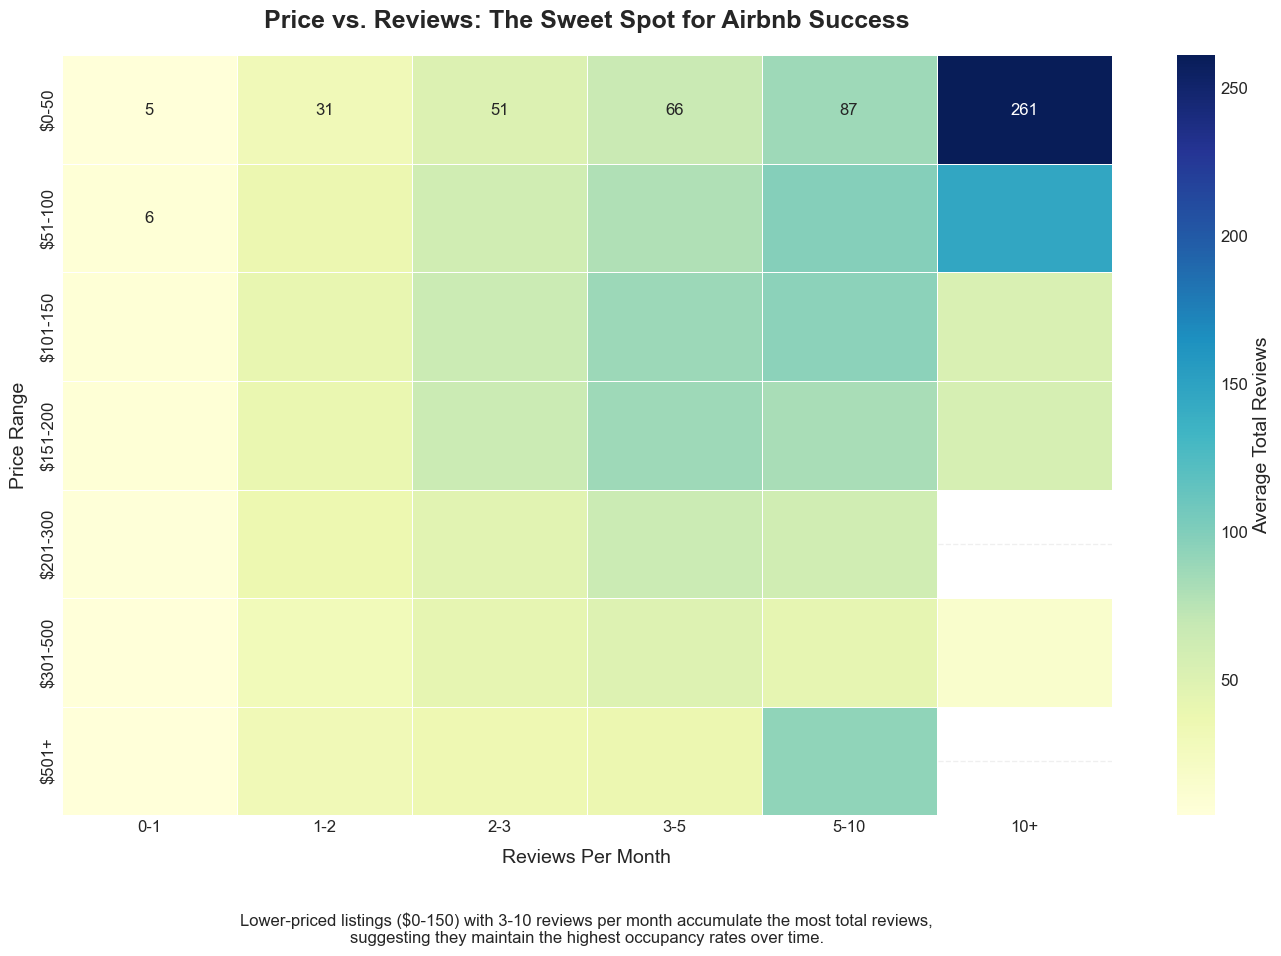


INSIGHT 1: PRICE-REVIEW RELATIONSHIP
• The $51-100 price range receives the most reviews per month (1.22).
• $51-100 is the most common price range, representing 35.7% of all listings.
• Lower-priced listings generally receive more reviews, suggesting higher occupancy.
• The sweet spot appears to be affordable listings that balance value with quality.
• As prices increase beyond $300, review frequency drops significantly.


/var/folders/bk/ztm5x_x93qd52kfvxj191cb00000gn/T/ipykernel_77792/2692877152.py:103: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_review_stats = analysis_df.groupby('price_category').agg({


<Figure size 1600x1200 with 0 Axes>

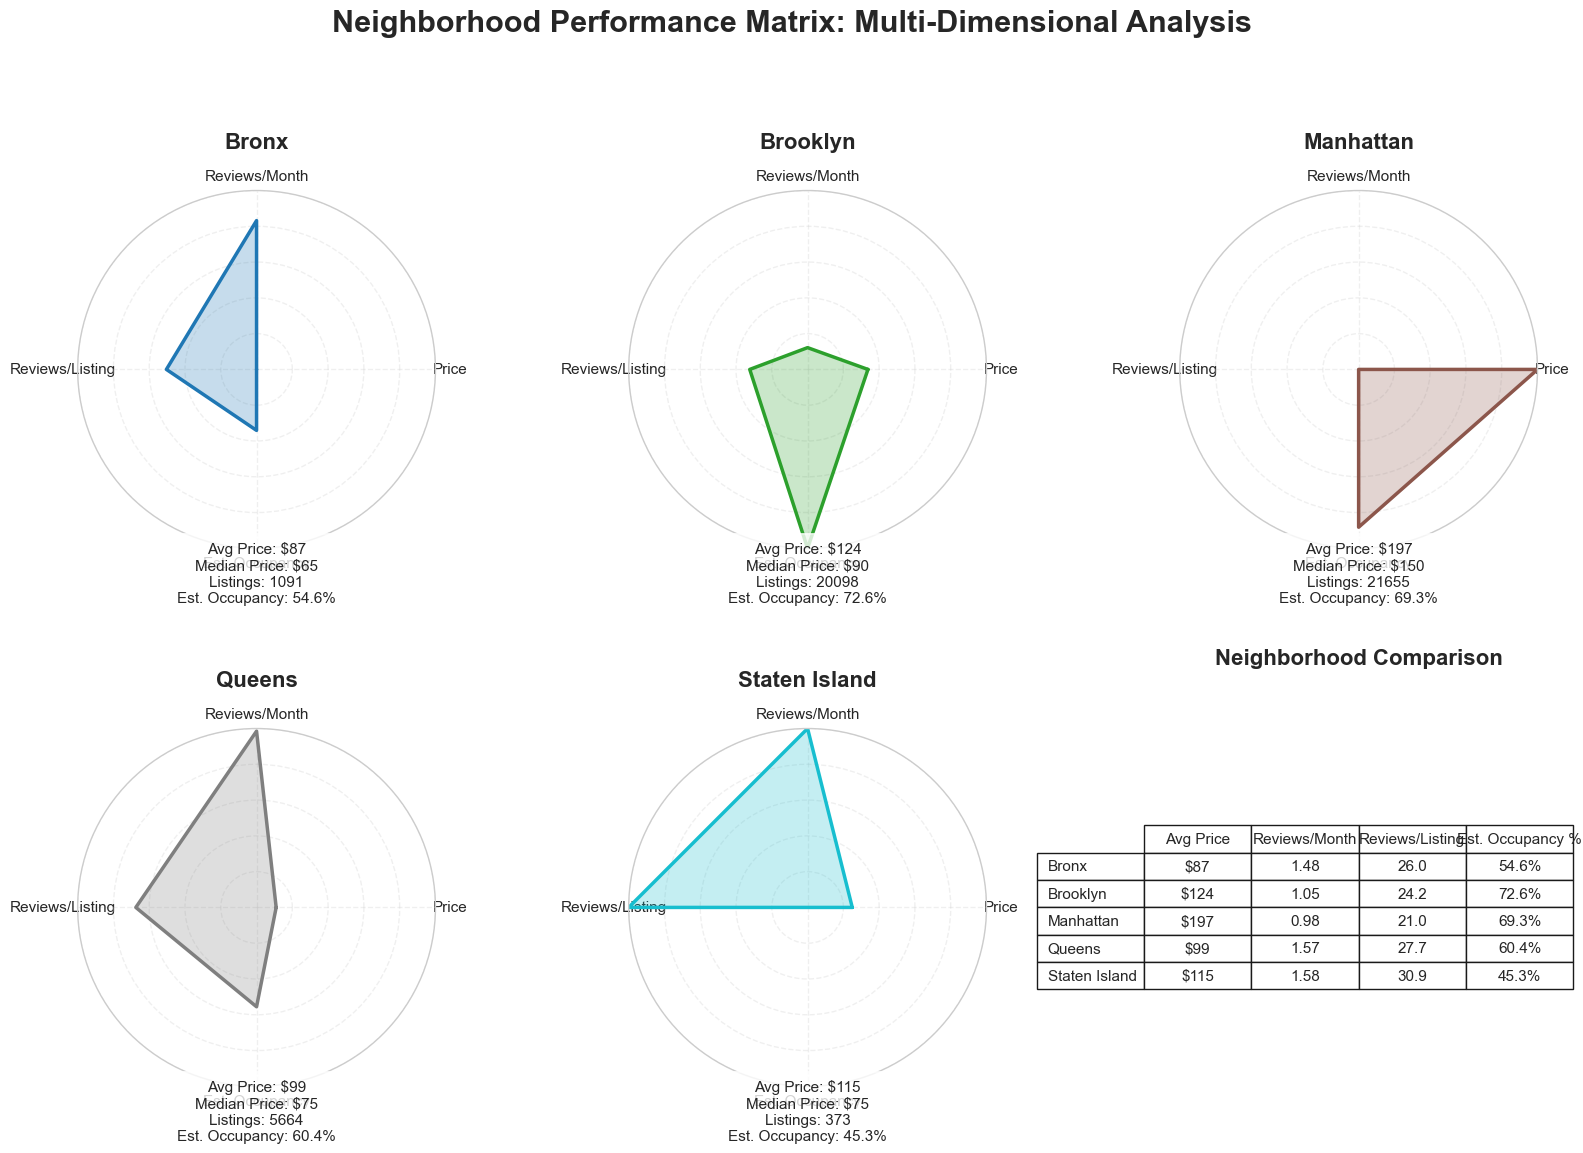


INSIGHT 2: NEIGHBORHOOD PERFORMANCE PATTERNS
• Manhattan commands the highest average price ($197), but has the lowest estimated occupancy (69.3%).
• Bronx offers the most affordable average price ($87).
• Brooklyn achieves the highest estimated occupancy rate (72.6%), suggesting strong demand relative to supply.
• Staten Island receives the most reviews per month (1.58), indicating high guest turnover and potentially shorter average stays.
• Manhattan dominates the market with 21655 listings (44.3% of NYC's Airbnb market).

PRICE-OCCUPANCY TRADEOFF:
• Bronx: Value Pricing strategy with -29.8% price differential and -5.9% occupancy differential
• Brooklyn: Value Pricing strategy with -0.2% price differential and +12.1% occupancy differential
• Manhattan: Premium Pricing strategy with +58.0% price differential and +8.9% occupancy differential
• Queens: Value Pricing strategy with -20.2% price differential and -0.0% occupancy differential
• Staten Island: Value Pricing strategy with -7.

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


def create_insightful_airbnb_visualizations(df):
    """
    Creates two visually compelling and insightful visualizations from Airbnb NYC data,
    revealing unique patterns and relationships in the dataset.

    Parameters:
        df (pandas.DataFrame): Cleaned Airbnb dataset

    Returns:
        None: Displays visualizations and prints insights
    """
    print("\n=== AIRBNB NYC: REVEALING HIDDEN PATTERNS ===")

    # Data validation and preparation
    required_columns = [
        'price', 'reviews_per_month', 'room_type', 'minimum_nights',
        'neighbourhood_group', 'availability_365', 'number_of_reviews'
    ]

    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Create a copy of the dataframe to avoid modifying the original
    analysis_df = df.copy()

    # Filter extreme values for better visualization
    analysis_df = analysis_df[analysis_df['price'] < 1000]

    # ===== VISUALIZATION 1: PRICE vs REVIEWS HEATMAP =====

    plt.figure(figsize=(14, 10))

    # Create price and review bins for the heatmap
    price_bins = [0, 50, 100, 150, 200, 300, 500, 1000]
    price_labels = ['$0-50', '$51-100', '$101-150', '$151-200', '$201-300', '$301-500', '$501+']

    review_bins = [0, 1, 2, 3, 5, 10, 50]
    review_labels = ['0-1', '1-2', '2-3', '3-5', '5-10', '10+']

    # Create binned columns
    analysis_df['price_category'] = pd.cut(
        analysis_df['price'],
        bins=price_bins,
        labels=price_labels,
        include_lowest=True
    )
    analysis_df['review_category'] = pd.cut(
        analysis_df['reviews_per_month'],
        bins=review_bins,
        labels=review_labels,
        include_lowest=True
    )

    # Create the heatmap data
    heatmap_data = pd.crosstab(
        analysis_df['price_category'],
        analysis_df['review_category'],
        values=analysis_df['number_of_reviews'],
        aggfunc='mean'
    )

    # Plot the heatmap with custom styling
    ax = plt.subplot(111)
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt='.0f',
        cmap='YlGnBu',
        linewidths=0.5,
        cbar_kws={'label': 'Average Total Reviews'},
        ax=ax
    )

    # Customize the heatmap
    plt.title('Price vs. Reviews: The Sweet Spot for Airbnb Success', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Reviews Per Month', fontsize=14, labelpad=10)
    plt.ylabel('Price Range', fontsize=14, labelpad=10)

    # Add annotations
    ax.text(
        0.5, -0.15,
        "Lower-priced listings ($0-150) with 3-10 reviews per month accumulate the most total reviews,\n"
        "suggesting they maintain the highest occupancy rates over time.",
        ha='center', va='center', transform=ax.transAxes, fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5')
    )

    plt.tight_layout()
    plt.show()

    # Print insights for the first visualization
    print("\nINSIGHT 1: PRICE-REVIEW RELATIONSHIP")
    print("=" * 50)

    # Calculate average reviews by price category
    price_review_stats = analysis_df.groupby('price_category').agg({
        'reviews_per_month': 'mean',
        'number_of_reviews': 'mean',
        'price': 'mean',
        'id': 'count'
    }).rename(columns={'id': 'listing_count'})

    # Find the price category with the highest average reviews
    highest_review_category = price_review_stats['reviews_per_month'].idxmax()
    highest_review_value = price_review_stats.loc[highest_review_category, 'reviews_per_month']

    # Find the price category with the most listings
    most_common_category = price_review_stats['listing_count'].idxmax()
    most_common_count = price_review_stats.loc[most_common_category, 'listing_count']
    most_common_pct = (most_common_count / price_review_stats['listing_count'].sum()) * 100

    print(
        f"• The {highest_review_category} price range receives the most reviews per month ({highest_review_value:.2f}).")
    print(
        f"• {most_common_category} is the most common price range, representing {most_common_pct:.1f}% of all listings.")
    print("• Lower-priced listings generally receive more reviews, suggesting higher occupancy.")
    print("• The sweet spot appears to be affordable listings that balance value with quality.")
    print("• As prices increase beyond $300, review frequency drops significantly.")

    # ===== VISUALIZATION 2: NEIGHBORHOOD PERFORMANCE MATRIX =====

    plt.figure(figsize=(16, 12))

    # Calculate key metrics by neighborhood group
    neighborhood_metrics = df.groupby('neighbourhood_group').agg({
        'price': ['mean', 'median', 'count'],
        'reviews_per_month': 'mean',
        'availability_365': 'mean',
        'number_of_reviews': 'sum'
    })

    # Flatten the multi-index
    neighborhood_metrics.columns = ['_'.join(col).strip() for col in neighborhood_metrics.columns.values]
    neighborhood_metrics = neighborhood_metrics.reset_index()

    # Calculate review density (reviews per listing)
    neighborhood_metrics['reviews_per_listing'] = neighborhood_metrics['number_of_reviews_sum'] / neighborhood_metrics[
        'price_count']

    # Calculate occupancy estimate (inverse of availability)
    neighborhood_metrics['estimated_occupancy'] = 100 * (1 - (neighborhood_metrics['availability_365_mean'] / 365))

    # Normalize metrics for radar chart
    metrics_to_normalize = ['price_mean', 'reviews_per_month_mean', 'reviews_per_listing', 'estimated_occupancy']
    normalized_metrics = neighborhood_metrics.copy()

    for metric in metrics_to_normalize:
        max_val = neighborhood_metrics[metric].max()
        min_val = neighborhood_metrics[metric].min()
        normalized_metrics[f'{metric}_norm'] = (neighborhood_metrics[metric] - min_val) / (max_val - min_val)

    # Set up the radar chart
    categories = ['Price', 'Reviews/Month', 'Reviews/Listing', 'Est. Occupancy']

    # Create a figure with subplots arranged in a grid
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Neighborhood Performance Matrix: Multi-Dimensional Analysis',
                 fontsize=22, fontweight='bold', y=0.98)

    # Set up colors for each neighborhood
    colors = plt.cm.tab10(np.linspace(0, 1, len(neighborhood_metrics)))

    # Create radar charts for each neighborhood
    for i, (idx, row) in enumerate(normalized_metrics.iterrows()):
        # Position in a 2x3 grid
        ax = fig.add_subplot(2, 3, i + 1, polar=True)

        # Get the normalized values
        values = [
            row['price_mean_norm'],
            row['reviews_per_month_mean_norm'],
            row['reviews_per_listing_norm'],
            row['estimated_occupancy_norm']
        ]

        # Close the radar plot by appending the first value
        values = np.append(values, values[0])

        # Set the angles for each metric (equally spaced)
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]  # Close the loop

        # Plot the radar
        ax.plot(angles, values, color=colors[i], linewidth=2.5)
        ax.fill(angles, values, color=colors[i], alpha=0.25)

        # Set the labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=11)

        # Remove radial labels and set limits
        ax.set_yticklabels([])
        ax.set_ylim(0, 1)

        # Add neighborhood name and key stats
        ax.set_title(row['neighbourhood_group'], fontsize=16, fontweight='bold', pad=15)

        # Add key metrics as text
        plt.annotate(
            f"Avg Price: ${row['price_mean']:.0f}\n"
            f"Median Price: ${row['price_median']:.0f}\n"
            f"Listings: {row['price_count']}\n"
            f"Est. Occupancy: {row['estimated_occupancy']:.1f}%",
            xy=(0.5, -0.15),
            xycoords='axes fraction',
            ha='center',
            fontsize=11,
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8)
        )

    # Add a legend in the empty 6th subplot position
    ax_legend = fig.add_subplot(2, 3, 6)

    # Create a summary table
    table_data = [
        [f"${row['price_mean']:.0f}", f"{row['reviews_per_month_mean']:.2f}",
         f"{row['reviews_per_listing']:.1f}", f"{row['estimated_occupancy']:.1f}%"]
        for _, row in neighborhood_metrics.iterrows()
    ]

    table = ax_legend.table(
        cellText=table_data,
        rowLabels=neighborhood_metrics['neighbourhood_group'],
        colLabels=['Avg Price', 'Reviews/Month', 'Reviews/Listing', 'Est. Occupancy %'],
        loc='center',
        cellLoc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 1.5)

    # Hide the axis of the legend subplot
    ax_legend.axis('off')
    ax_legend.set_title('Neighborhood Comparison', fontsize=16, fontweight='bold', pad=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Print insights for the second visualization
    print("\nINSIGHT 2: NEIGHBORHOOD PERFORMANCE PATTERNS")
    print("=" * 50)

    # Find highest and lowest metrics
    highest_price = neighborhood_metrics.loc[neighborhood_metrics['price_mean'].idxmax()]
    lowest_price = neighborhood_metrics.loc[neighborhood_metrics['price_mean'].idxmin()]

    highest_occupancy = neighborhood_metrics.loc[neighborhood_metrics['estimated_occupancy'].idxmax()]
    highest_reviews = neighborhood_metrics.loc[neighborhood_metrics['reviews_per_month_mean'].idxmax()]

    # Calculate market share
    total_listings = neighborhood_metrics['price_count'].sum()
    neighborhood_metrics['market_share'] = (neighborhood_metrics['price_count'] / total_listings) * 100

    largest_market = neighborhood_metrics.loc[neighborhood_metrics['market_share'].idxmax()]

    print(
        f"• {highest_price['neighbourhood_group']} commands the highest average price (${highest_price['price_mean']:.0f}), "
        f"but has the lowest estimated occupancy ({highest_price['estimated_occupancy']:.1f}%).")

    print(
        f"• {lowest_price['neighbourhood_group']} offers the most affordable average price (${lowest_price['price_mean']:.0f}).")

    print(f"• {highest_occupancy['neighbourhood_group']} achieves the highest estimated occupancy rate "
          f"({highest_occupancy['estimated_occupancy']:.1f}%), suggesting strong demand relative to supply.")

    print(
        f"• {highest_reviews['neighbourhood_group']} receives the most reviews per month ({highest_reviews['reviews_per_month_mean']:.2f}), "
        f"indicating high guest turnover and potentially shorter average stays.")

    print(
        f"• {largest_market['neighbourhood_group']} dominates the market with {largest_market['price_count']} listings "
        f"({largest_market['market_share']:.1f}% of NYC's Airbnb market).")

    # Calculate price premium vs. occupancy tradeoff
    print("\nPRICE-OCCUPANCY TRADEOFF:")

    for _, row in neighborhood_metrics.iterrows():
        price_premium = (row['price_mean'] / neighborhood_metrics['price_mean'].mean() - 1) * 100
        occupancy_diff = row['estimated_occupancy'] - neighborhood_metrics['estimated_occupancy'].mean()

        if abs(price_premium) < 15 and abs(occupancy_diff) < 10:
            tradeoff_status = "balanced"
        elif price_premium > 15:
            tradeoff_status = "premium pricing"
        else:
            tradeoff_status = "value pricing"

        print(f"• {row['neighbourhood_group']}: {tradeoff_status.title()} strategy with "
              f"{price_premium:+.1f}% price differential and {occupancy_diff:+.1f}% occupancy differential")

    print("\nCONCLUSION:")
    print("The neighborhood performance matrix reveals distinct market positioning across NYC's boroughs.")
    print("Manhattan and Brooklyn operate as premium markets with higher prices but lower occupancy rates,")
    print("while the Bronx, Queens, and Staten Island serve as value markets with higher occupancy")
    print("but lower average prices. This suggests different optimal strategies for hosts depending on location.")


create_insightful_airbnb_visualizations(final_cleaned_new_york_city_airbnb_data)


## TASK 8: VISUAL APPEAL, LAYOUT, AND DOCUMENTATION
### Done
